In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from scipy.fft import rfft, rfftfreq
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [10]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


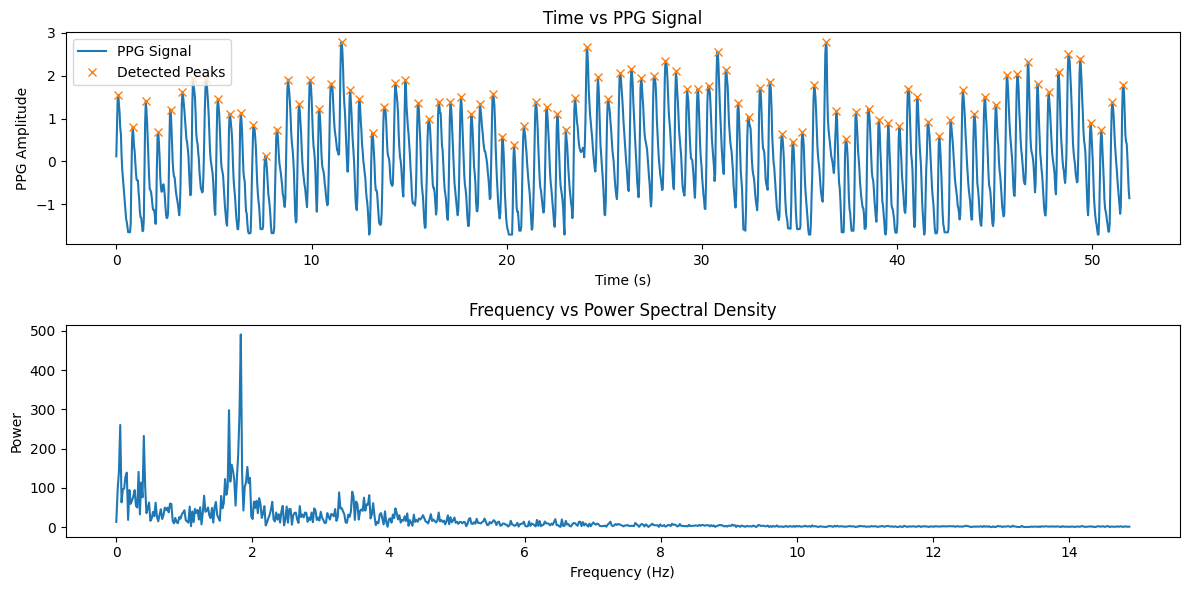

In [11]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [32]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = npz_data['wave']
    hr_real = npz_data['hr']  # 실제 심박수 데이터
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=10)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

    # hr_real을 times에 맞춰서 조정
    hr_real_adjusted = [hr_real[int(time * fps)] for time in times if int(time * fps) < len(hr_real)]

    return times, bpm_per_frame, hr_real_adjusted

def calculate_errors(bpm_per_frame, hr_real_filtered):
    # NaN이 아닌 인덱스를 찾습니다.
    valid_indices = ~np.isnan(bpm_per_frame) & ~np.isnan(hr_real_filtered)

    # 유효한 인덱스만 사용하여 데이터를 필터링합니다.
    filtered_bpm = np.array(bpm_per_frame)[valid_indices]
    filtered_hr_real = np.array(hr_real_filtered)[valid_indices]

    # MAE와 RMSE를 계산합니다.
    mae = mean_absolute_error(filtered_hr_real, filtered_bpm)
    rmse = np.sqrt(mean_squared_error(filtered_hr_real, filtered_bpm))

    return mae, rmse

def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    # plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.plot(times, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    # 계산된 BPM과 실제 HR의 평균 및 오류 메트릭 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)
    # mse = mean_squared_error([mean_actual_hr], [mean_estimated_bpm])
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error([mean_actual_hr], [mean_estimated_bpm])
    mae, rmse = calculate_errors(bpm_per_frame, hr_real_filtered)

    # 결과 출력
    print(f"Average Estimated Heart Rate: {mean_estimated_bpm:.2f}")
    print(f"Average Actual Heart Rate: {mean_actual_hr:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("---------------------------------------------------------------------------")

    return rmse, mae

def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    mse_list, rmse_list, mae_list = [], [], []
    subject_list = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame, hr_real = calculate_hr(npz_data)
            rmse, mae = plot_hr(times, bpm_per_frame, hr_real)
            # mse_list.append(mse)
            rmse_list.append(rmse)
            mae_list.append(mae)
            subject_list.append(file_name.replace('.npz', ''))

    return rmse_list, mae_list, subject_list

Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz...


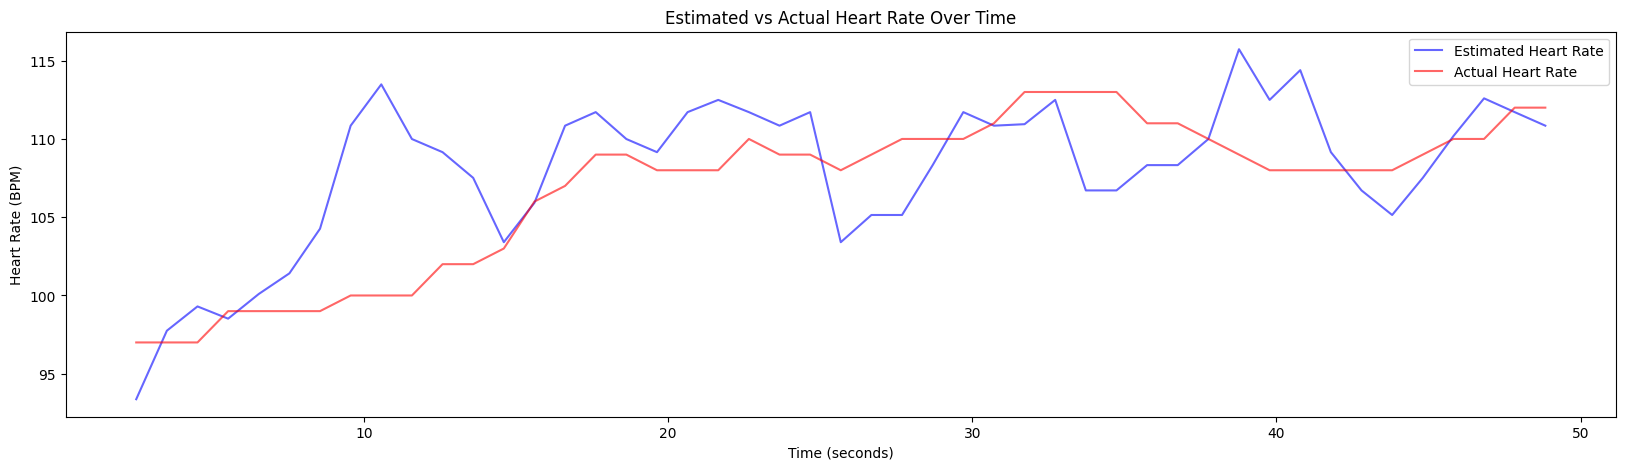

Average Estimated Heart Rate: 108.08
Average Actual Heart Rate: 106.83
MAE: 3.25
RMSE: 4.37
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz...


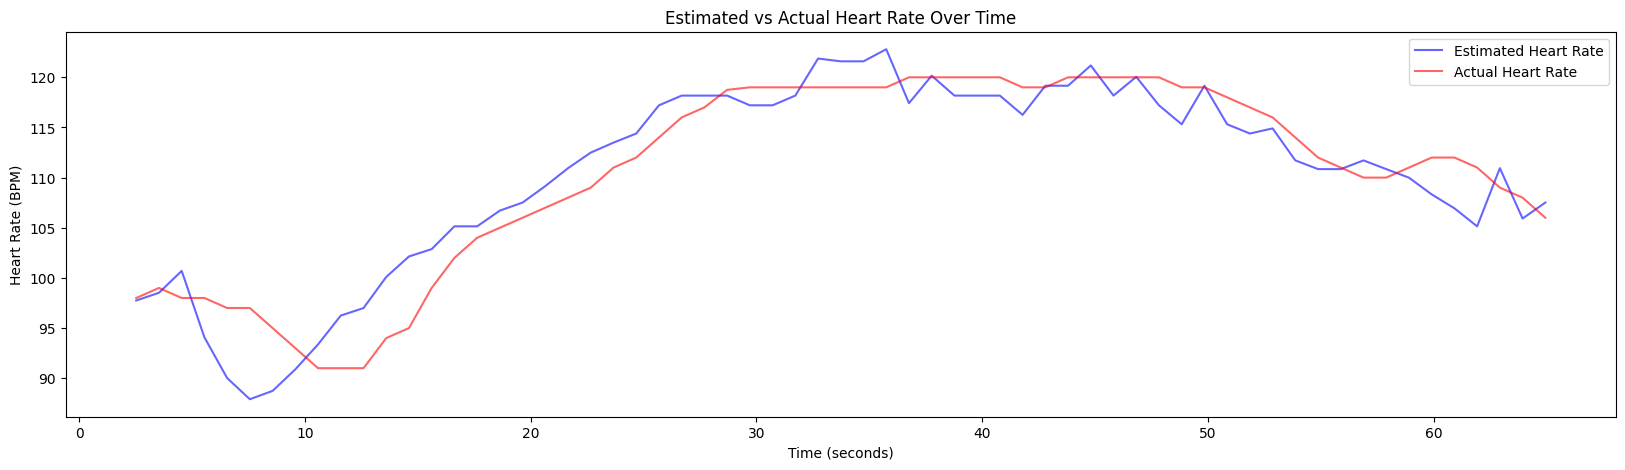

Average Estimated Heart Rate: 110.33
Average Actual Heart Rate: 110.35
MAE: 2.58
RMSE: 3.20
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz...


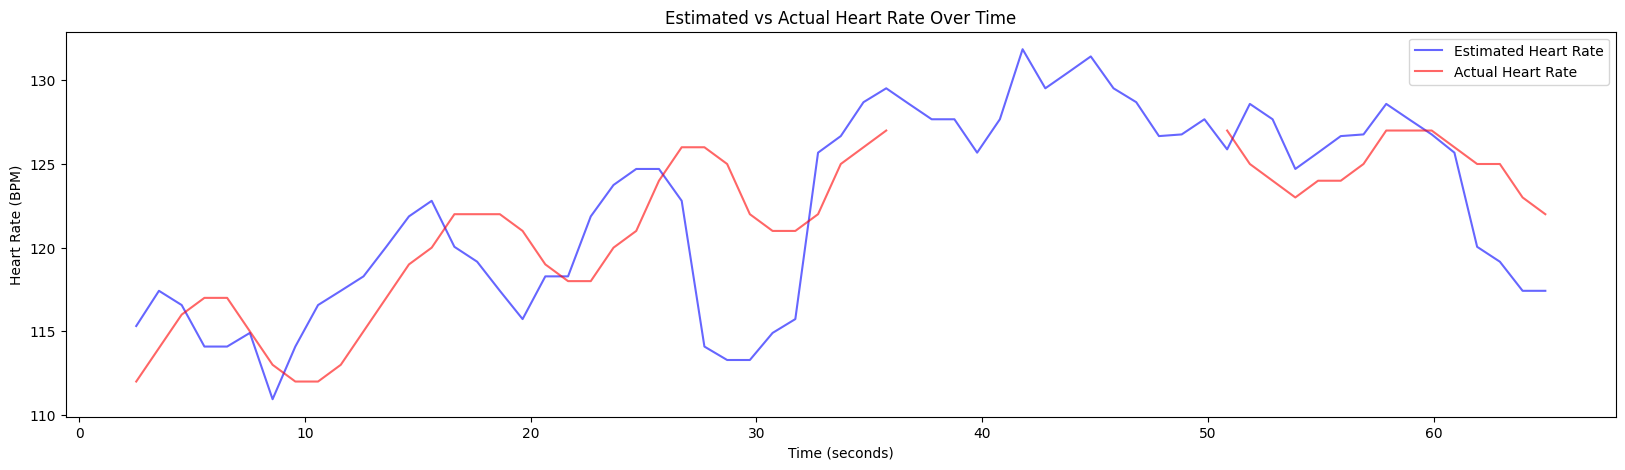

Average Estimated Heart Rate: 122.41
Average Actual Heart Rate: 121.10
MAE: 3.34
RMSE: 4.16
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz...


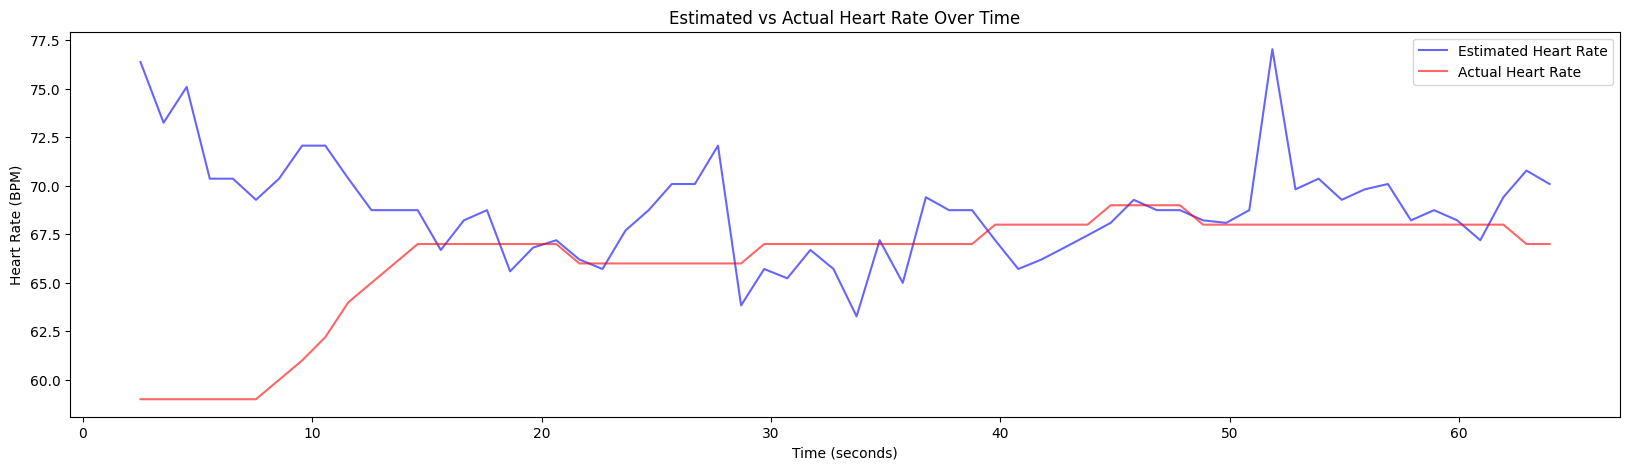

Average Estimated Heart Rate: 68.74
Average Actual Heart Rate: 66.15
MAE: 3.35
RMSE: 5.37
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz...


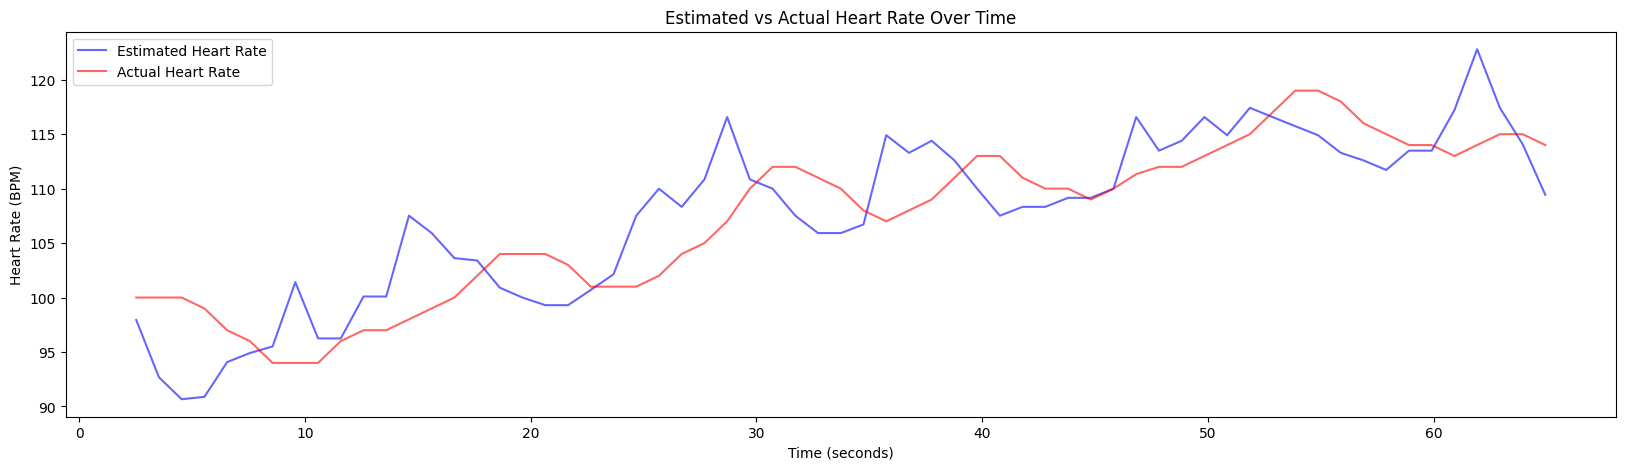

Average Estimated Heart Rate: 107.58
Average Actual Heart Rate: 107.20
MAE: 3.65
RMSE: 4.47
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz...


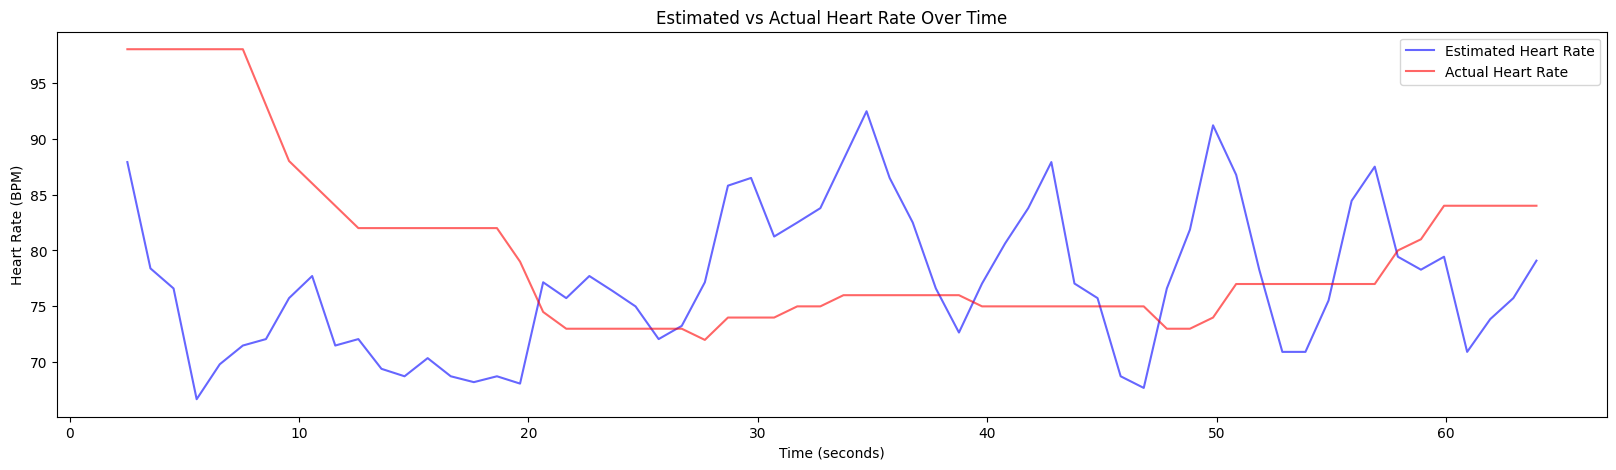

Average Estimated Heart Rate: 77.18
Average Actual Heart Rate: 79.75
MAE: 9.21
RMSE: 11.43
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject15.npz...


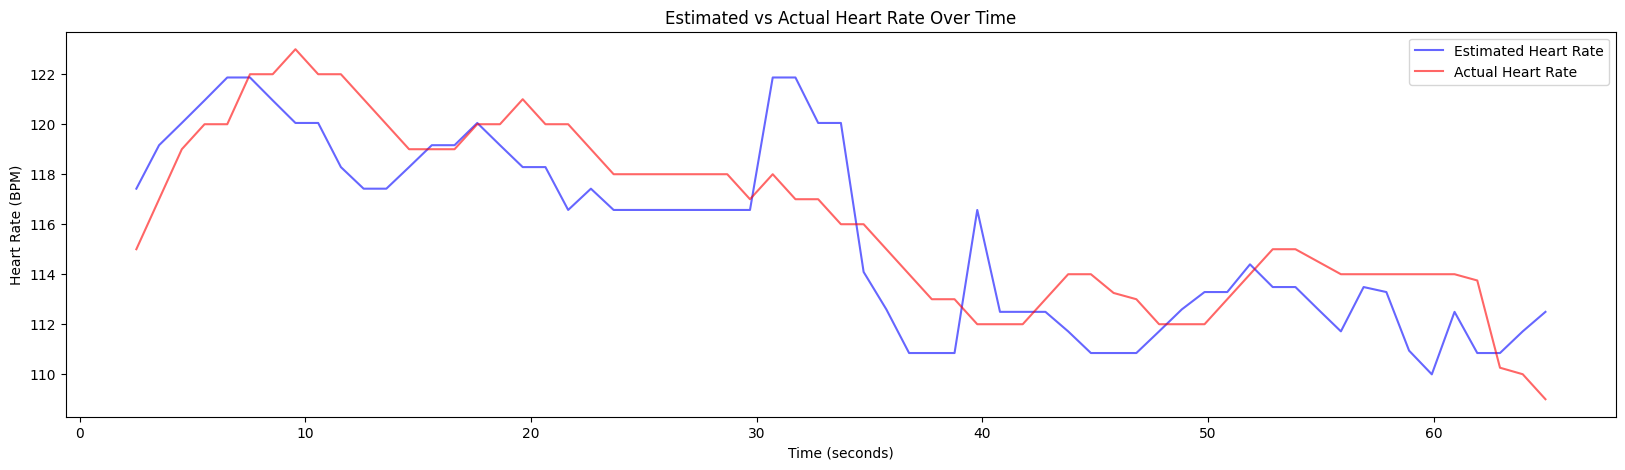

Average Estimated Heart Rate: 115.59
Average Actual Heart Rate: 116.22
MAE: 1.86
RMSE: 2.22
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject16.npz...


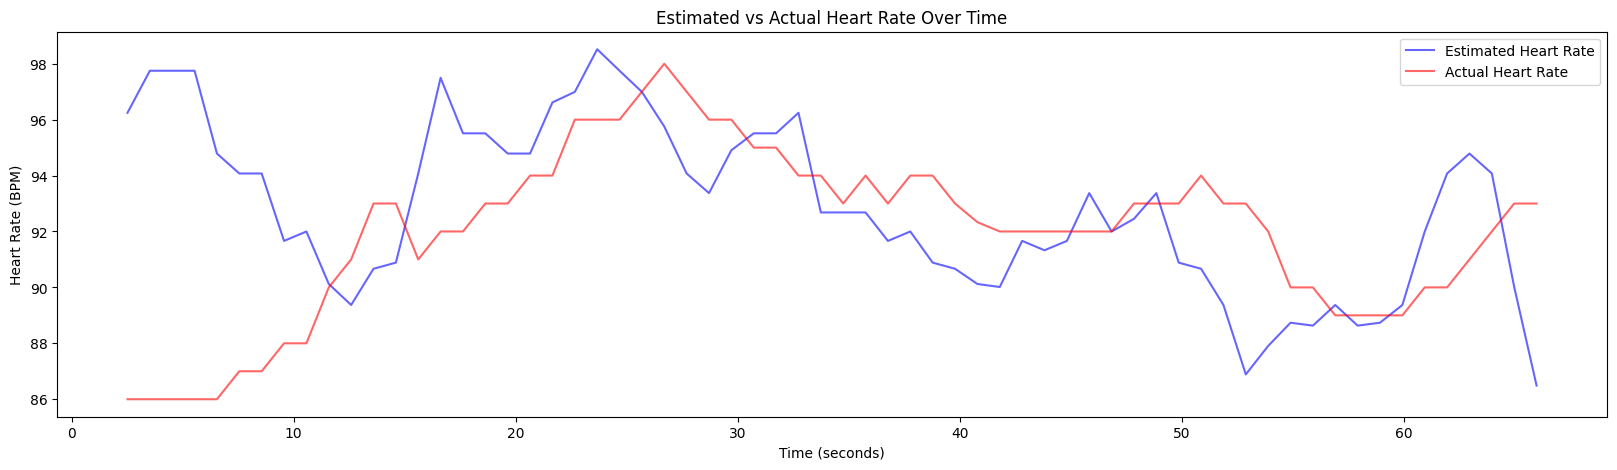

Average Estimated Heart Rate: 92.83
Average Actual Heart Rate: 91.99
MAE: 2.87
RMSE: 4.07
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject17.npz...


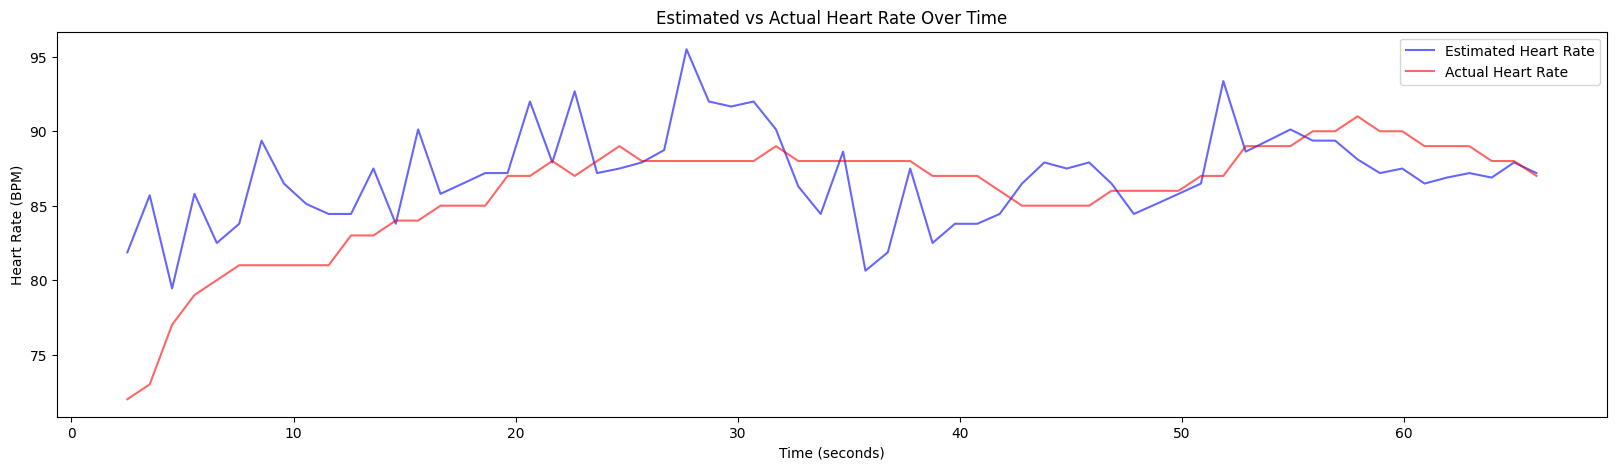

Average Estimated Heart Rate: 87.03
Average Actual Heart Rate: 85.92
MAE: 2.83
RMSE: 3.85
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject18.npz...


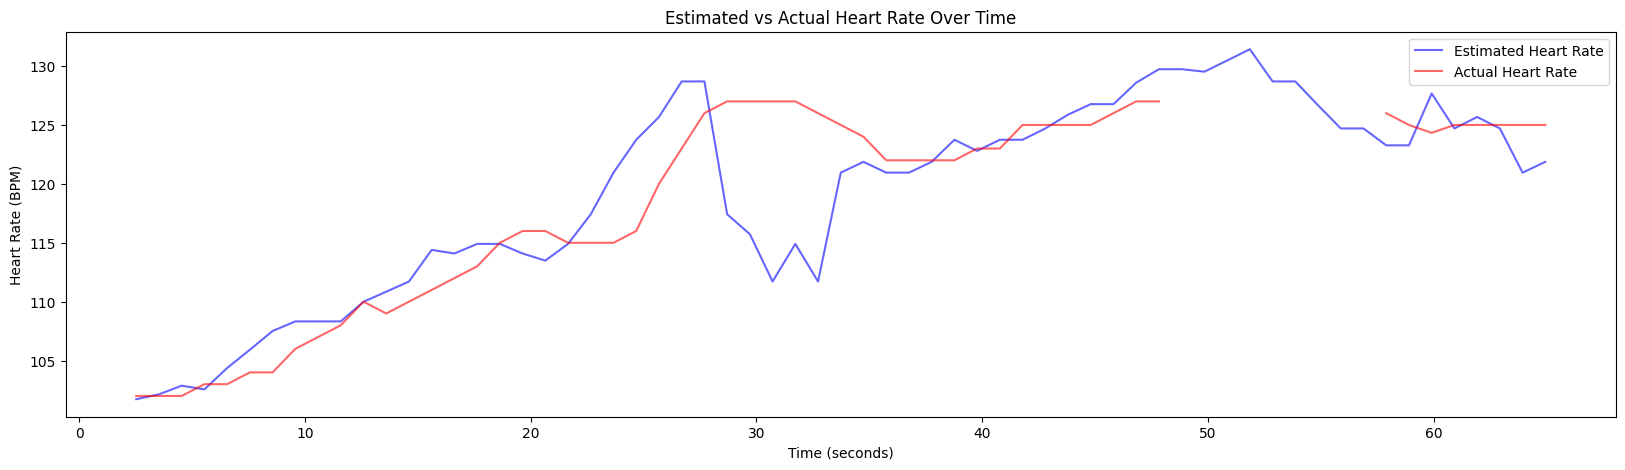

Average Estimated Heart Rate: 119.24
Average Actual Heart Rate: 118.15
MAE: 2.92
RMSE: 4.57
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject20.npz...


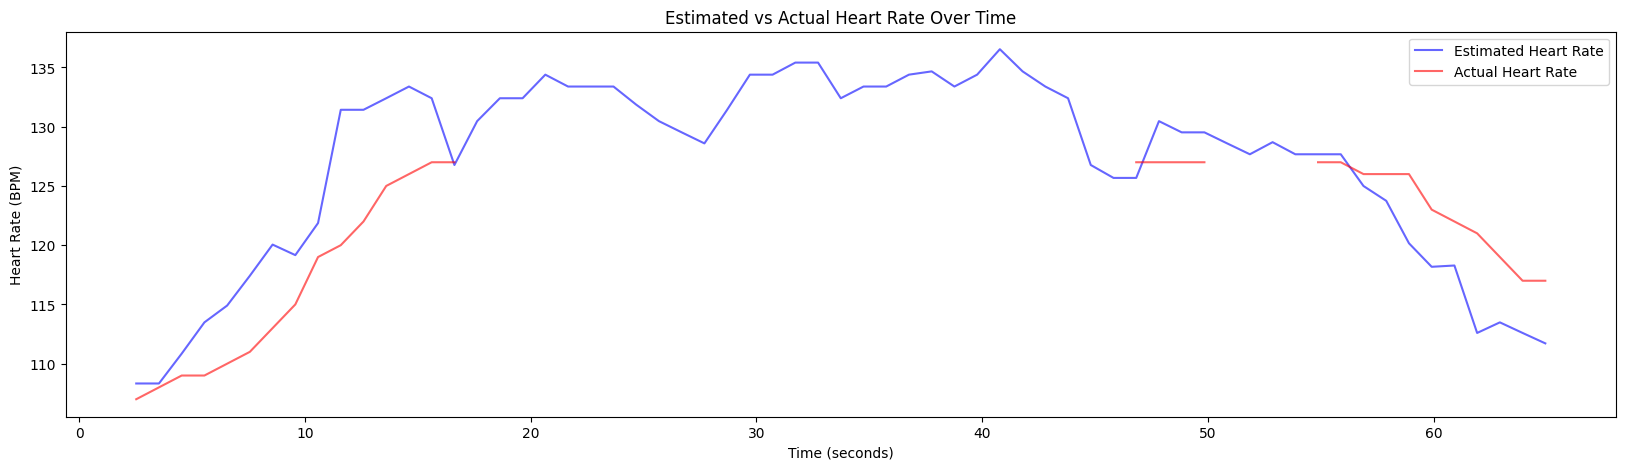

Average Estimated Heart Rate: 127.11
Average Actual Heart Rate: 120.23
MAE: 4.24
RMSE: 5.09
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject22.npz...


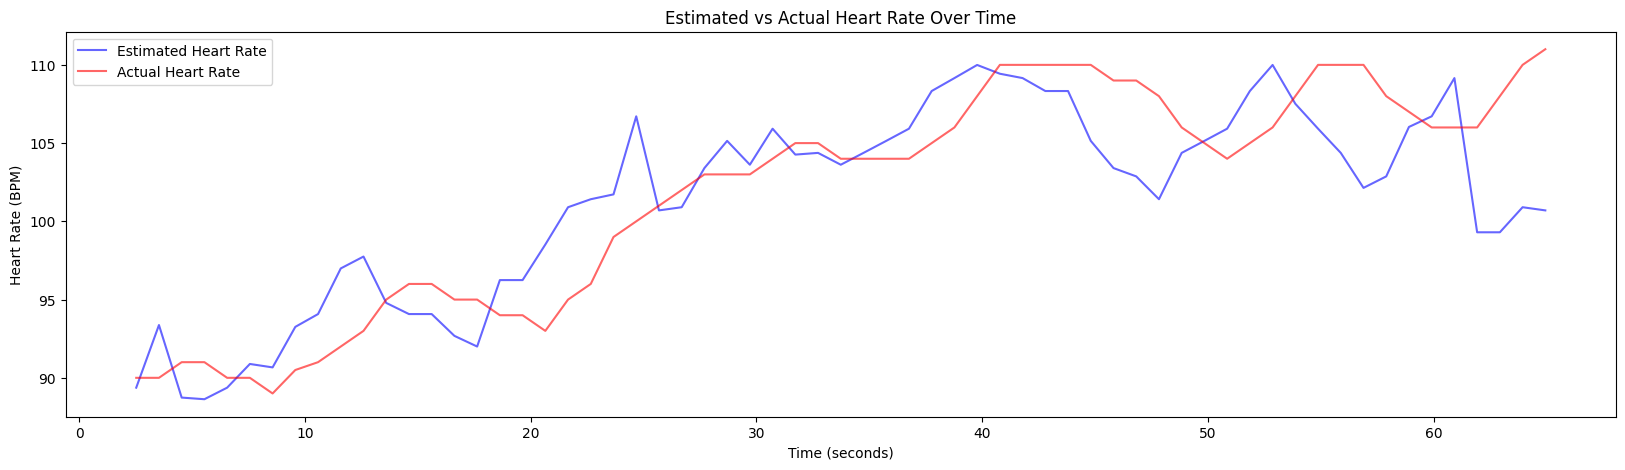

Average Estimated Heart Rate: 101.34
Average Actual Heart Rate: 101.72
MAE: 3.01
RMSE: 3.87
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject23.npz...


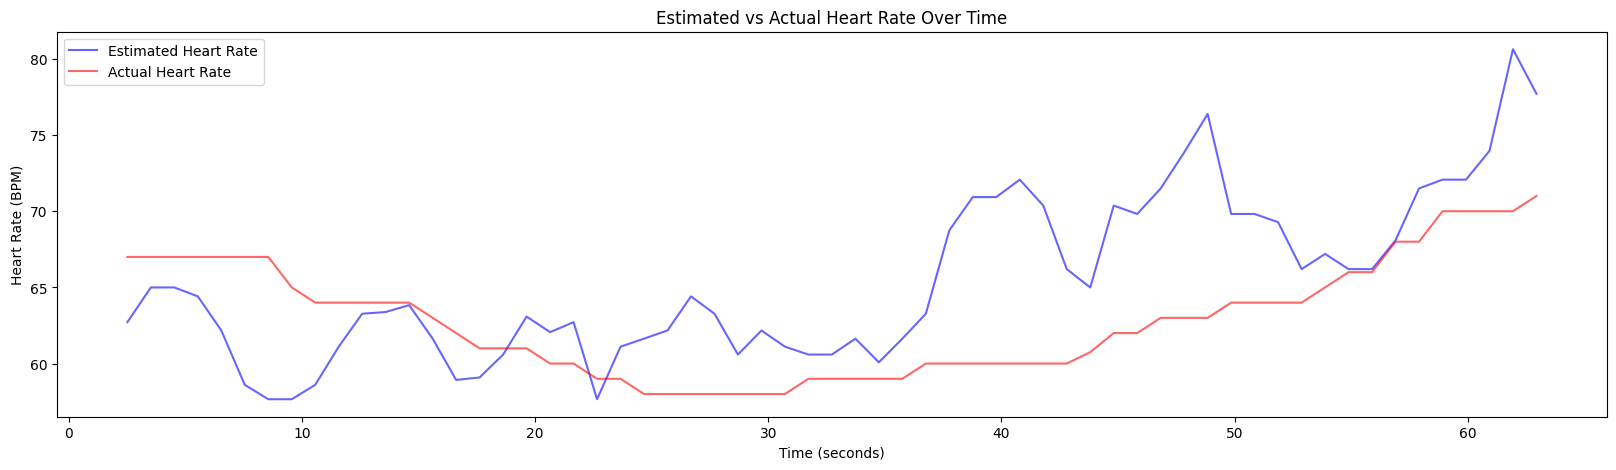

Average Estimated Heart Rate: 65.42
Average Actual Heart Rate: 62.86
MAE: 4.48
RMSE: 5.63
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject24.npz...


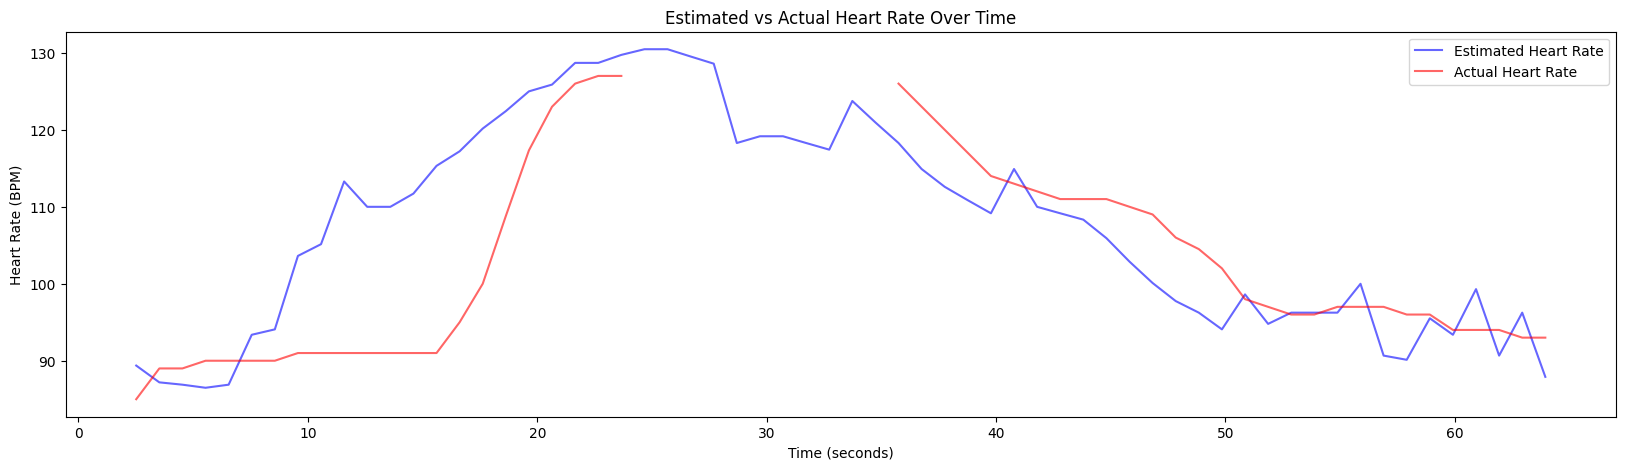

Average Estimated Heart Rate: 107.71
Average Actual Heart Rate: 102.19
MAE: 6.93
RMSE: 9.52
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject25.npz...


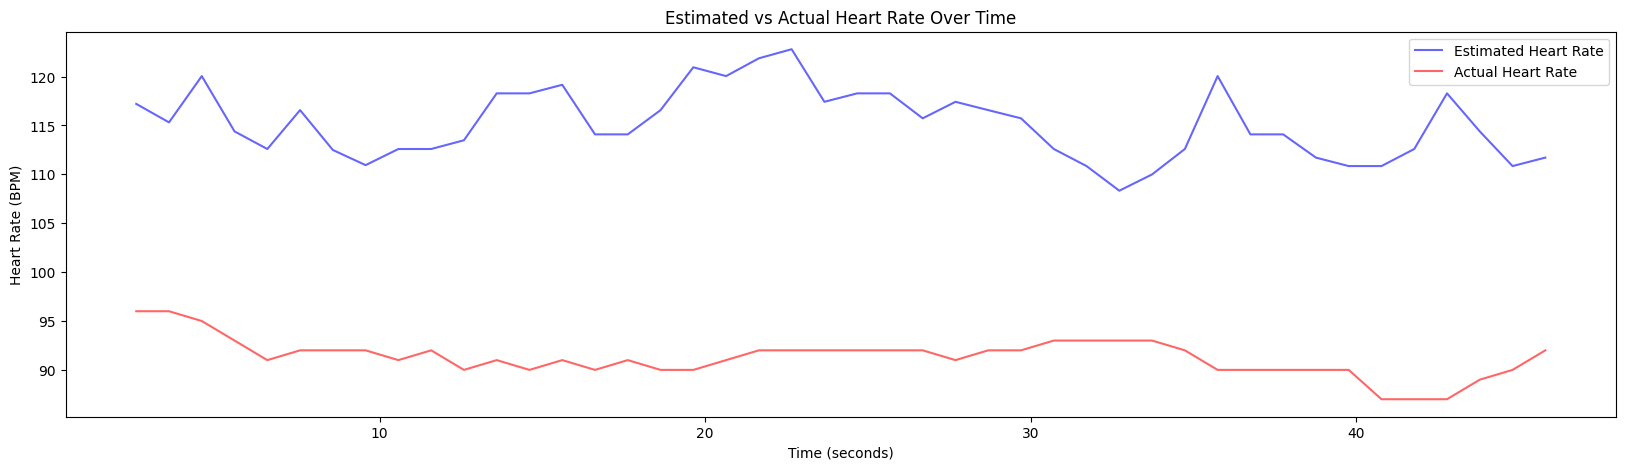

Average Estimated Heart Rate: 115.17
Average Actual Heart Rate: 91.30
MAE: 23.88
RMSE: 24.19
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject26.npz...


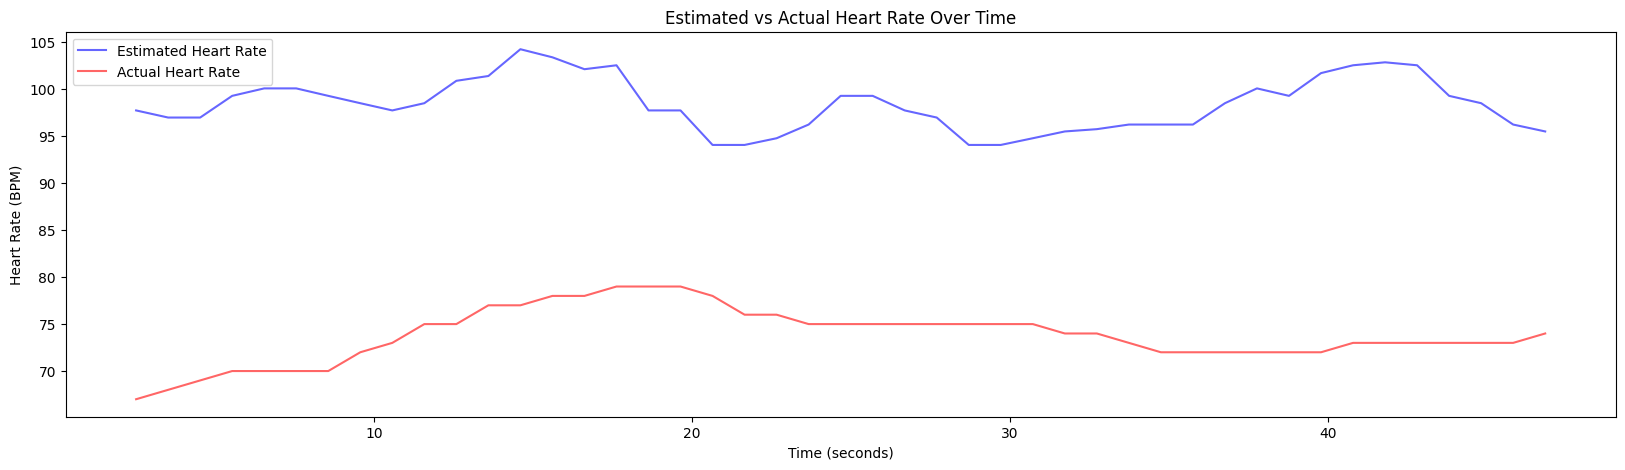

Average Estimated Heart Rate: 98.40
Average Actual Heart Rate: 73.80
MAE: 24.60
RMSE: 24.91
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject27.npz...


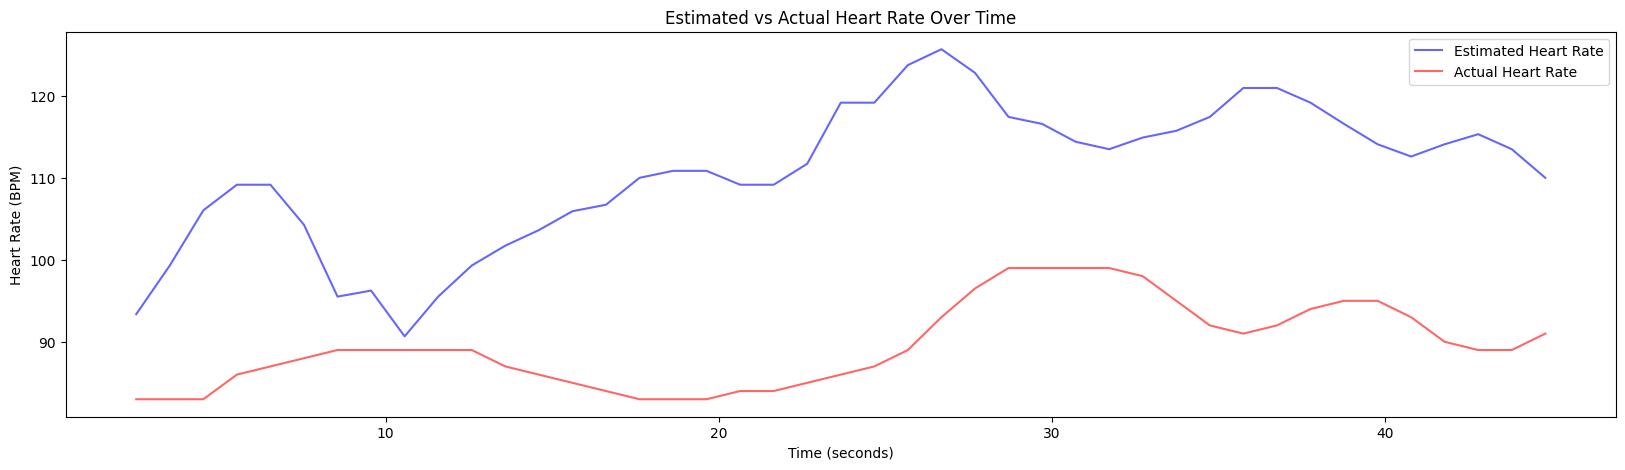

Average Estimated Heart Rate: 110.60
Average Actual Heart Rate: 89.55
MAE: 21.06
RMSE: 22.39
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject3.npz...


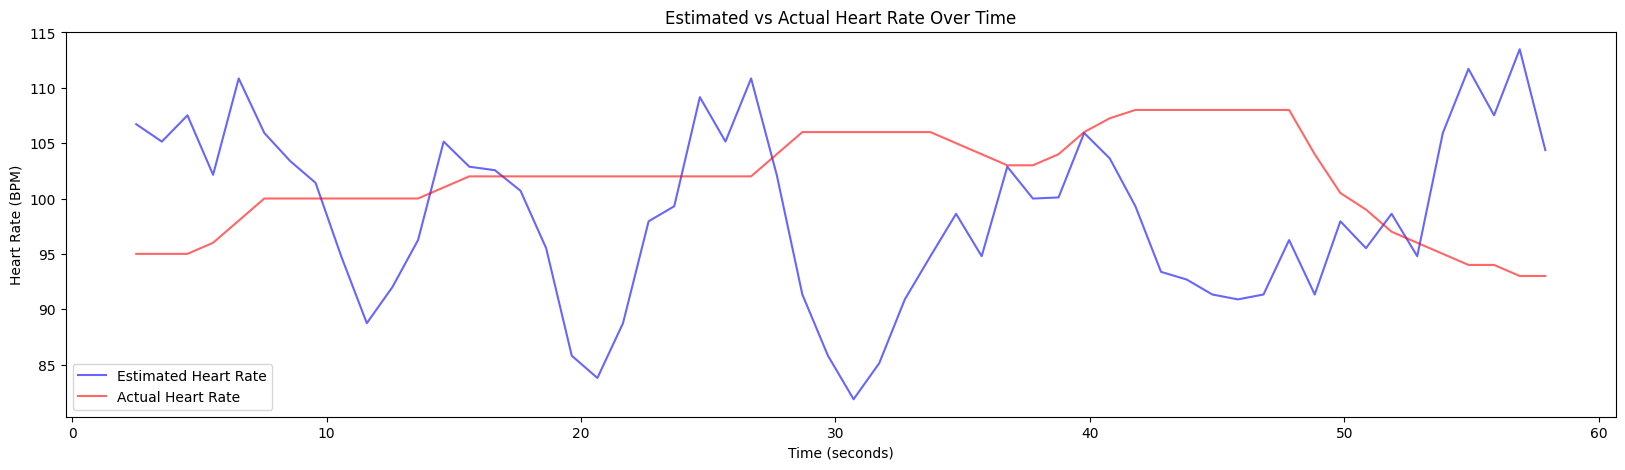

Average Estimated Heart Rate: 98.51
Average Actual Heart Rate: 101.75
MAE: 9.11
RMSE: 11.10
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject30.npz...


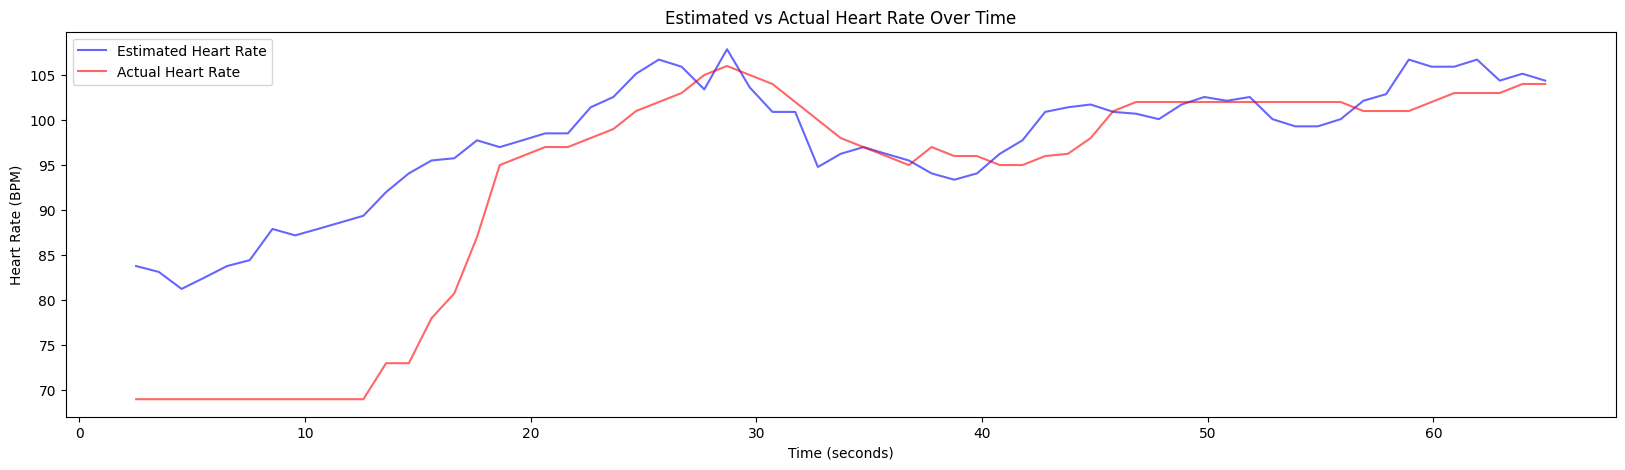

Average Estimated Heart Rate: 97.75
Average Actual Heart Rate: 93.00
MAE: 5.84
RMSE: 8.76
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject31.npz...


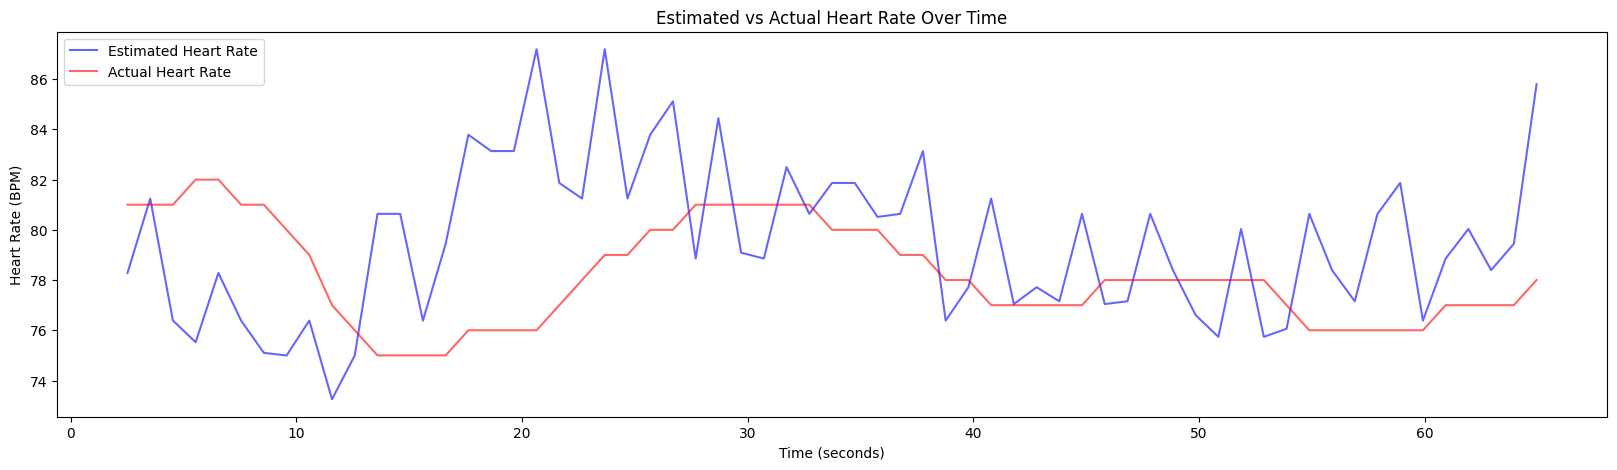

Average Estimated Heart Rate: 79.54
Average Actual Heart Rate: 78.19
MAE: 3.17
RMSE: 3.96
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject32.npz...


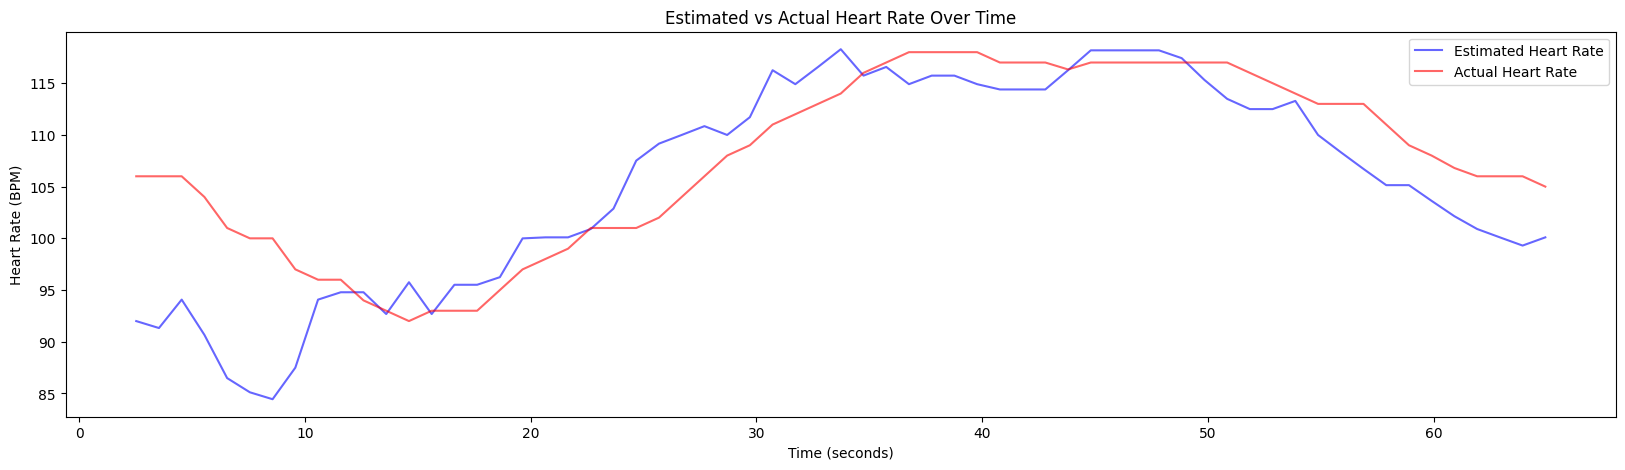

Average Estimated Heart Rate: 105.47
Average Actual Heart Rate: 107.53
MAE: 4.25
RMSE: 5.86
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject33.npz...


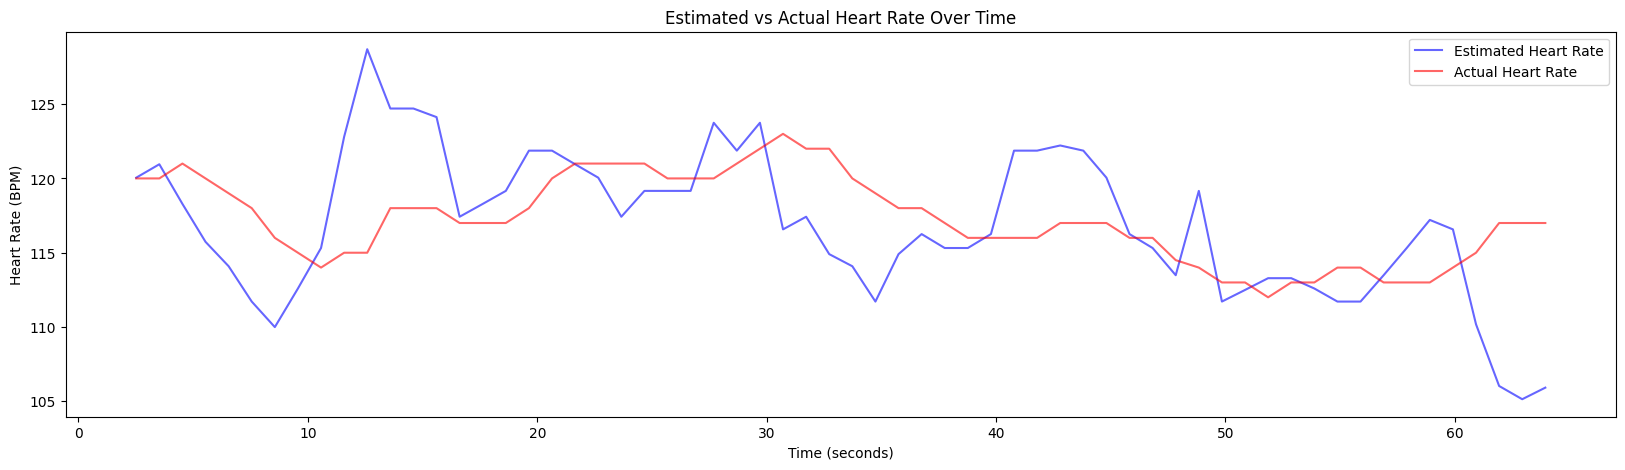

Average Estimated Heart Rate: 116.92
Average Actual Heart Rate: 117.23
MAE: 3.57
RMSE: 4.74
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject34.npz...


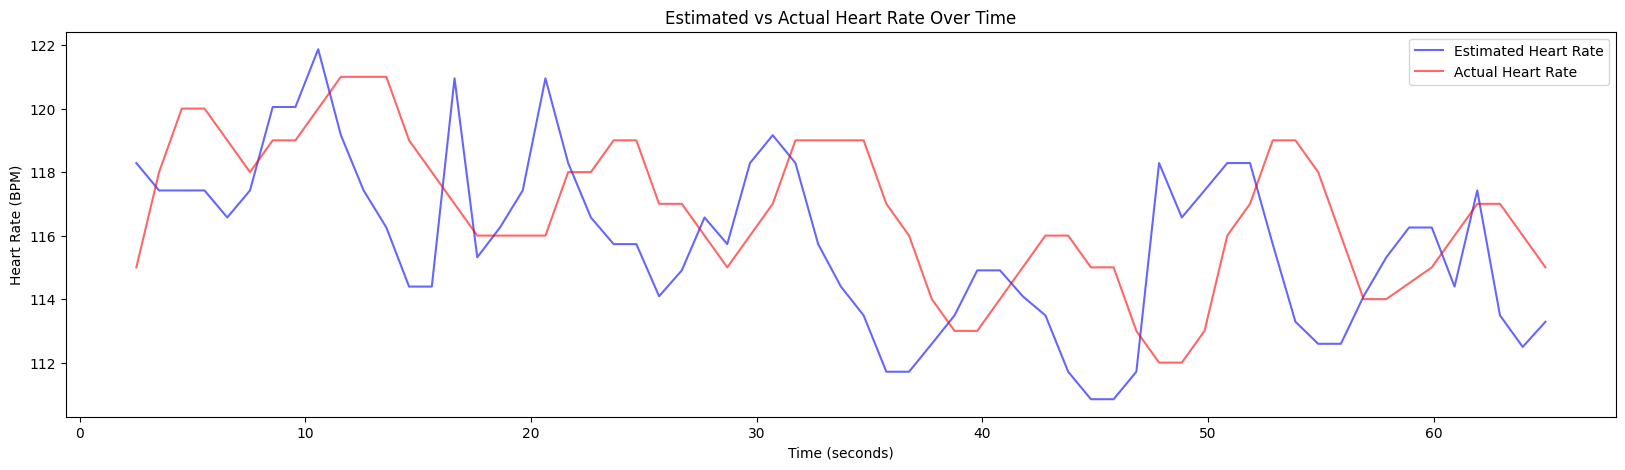

Average Estimated Heart Rate: 115.78
Average Actual Heart Rate: 116.74
MAE: 2.57
RMSE: 3.05
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject35.npz...


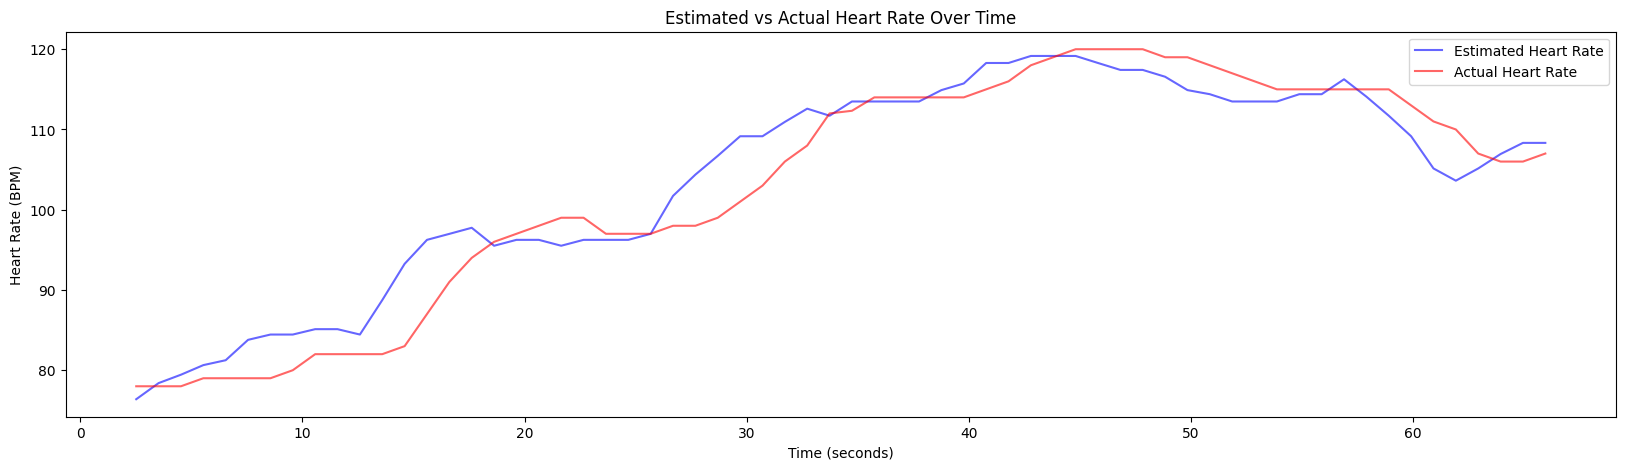

Average Estimated Heart Rate: 103.87
Average Actual Heart Rate: 102.93
MAE: 2.91
RMSE: 3.74
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject36.npz...


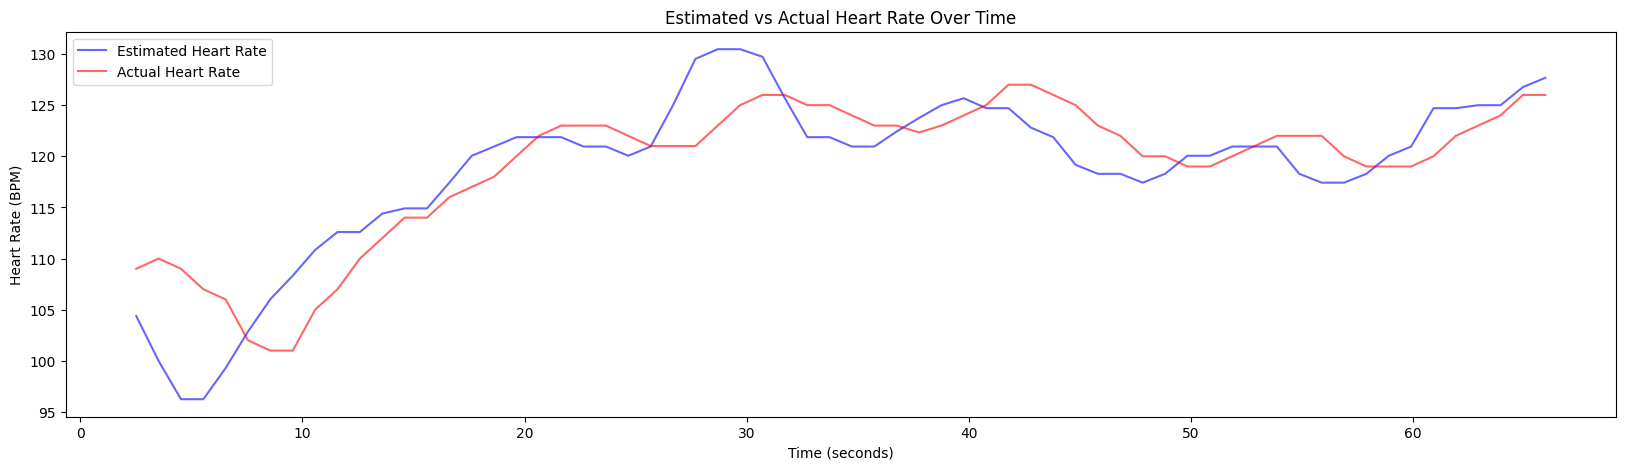

Average Estimated Heart Rate: 118.89
Average Actual Heart Rate: 119.08
MAE: 3.13
RMSE: 4.11
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject37.npz...


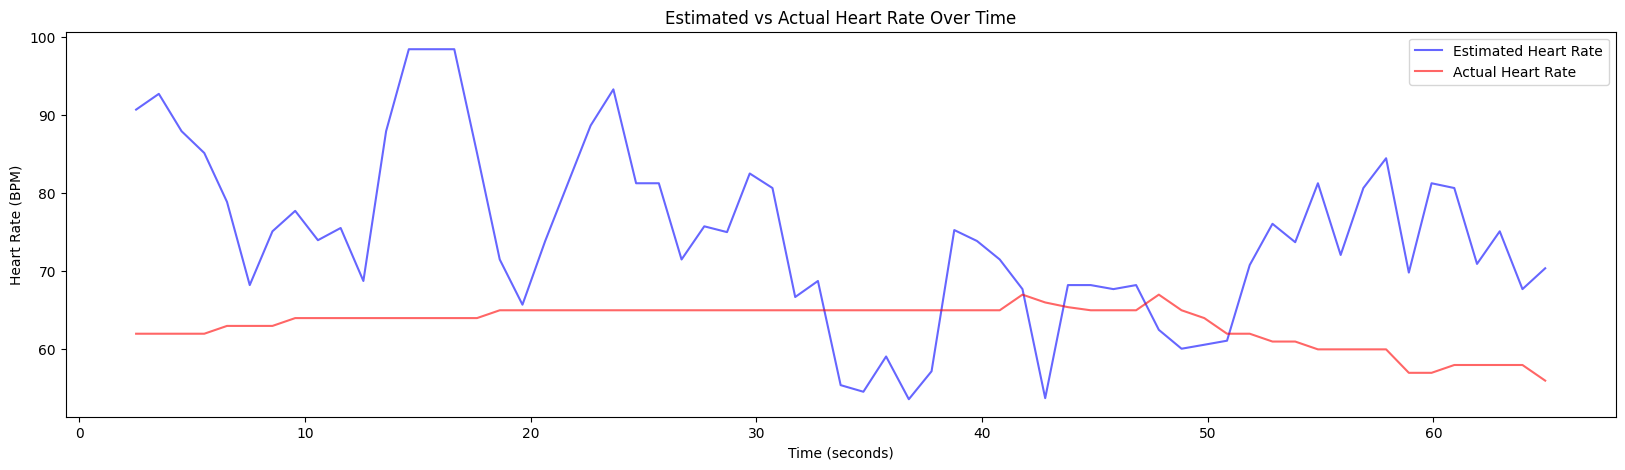

Average Estimated Heart Rate: 74.50
Average Actual Heart Rate: 63.26
MAE: 13.50
RMSE: 16.18
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject38.npz...


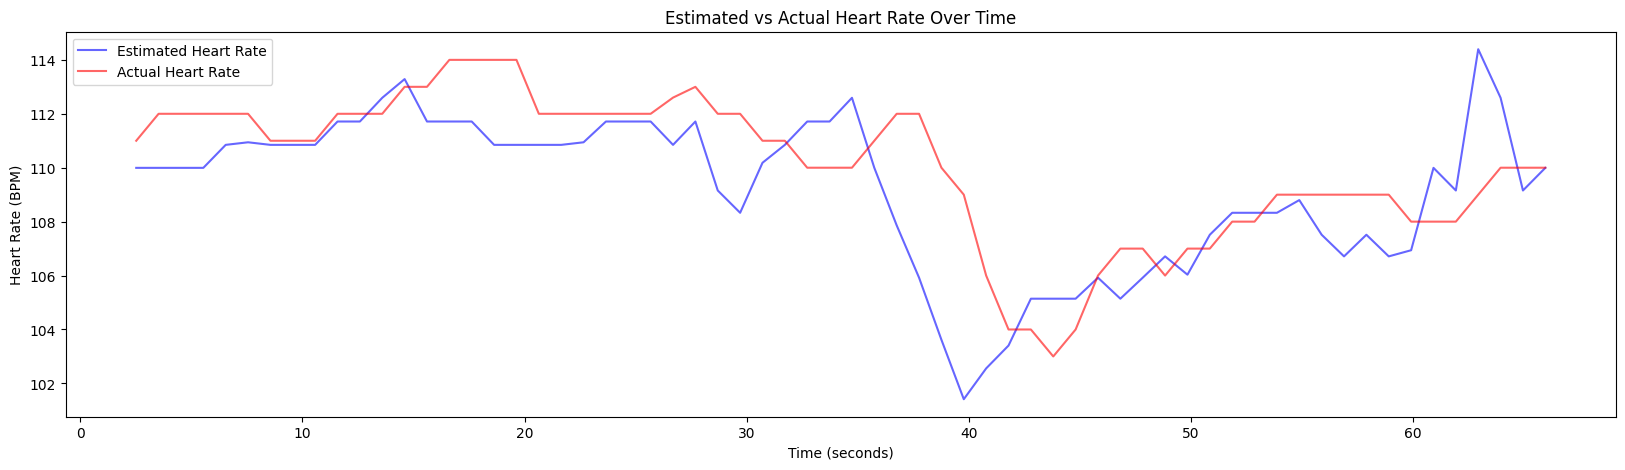

Average Estimated Heart Rate: 109.18
Average Actual Heart Rate: 110.06
MAE: 1.64
RMSE: 2.27
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject39.npz...


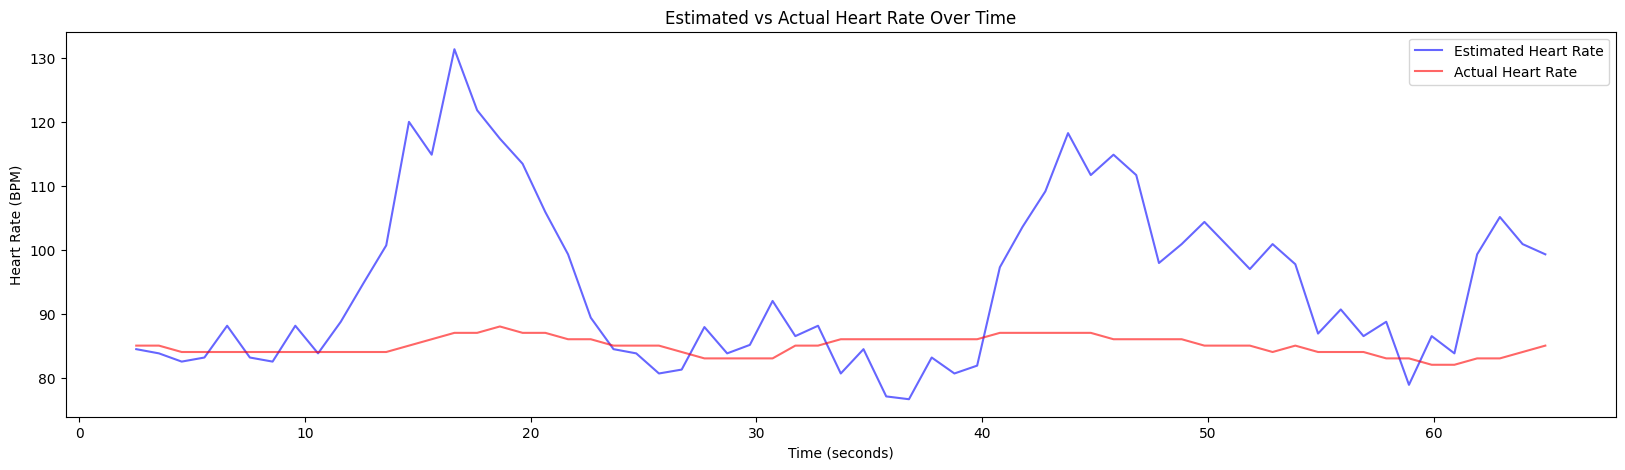

Average Estimated Heart Rate: 94.42
Average Actual Heart Rate: 84.95
MAE: 11.28
RMSE: 15.51
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject4.npz...


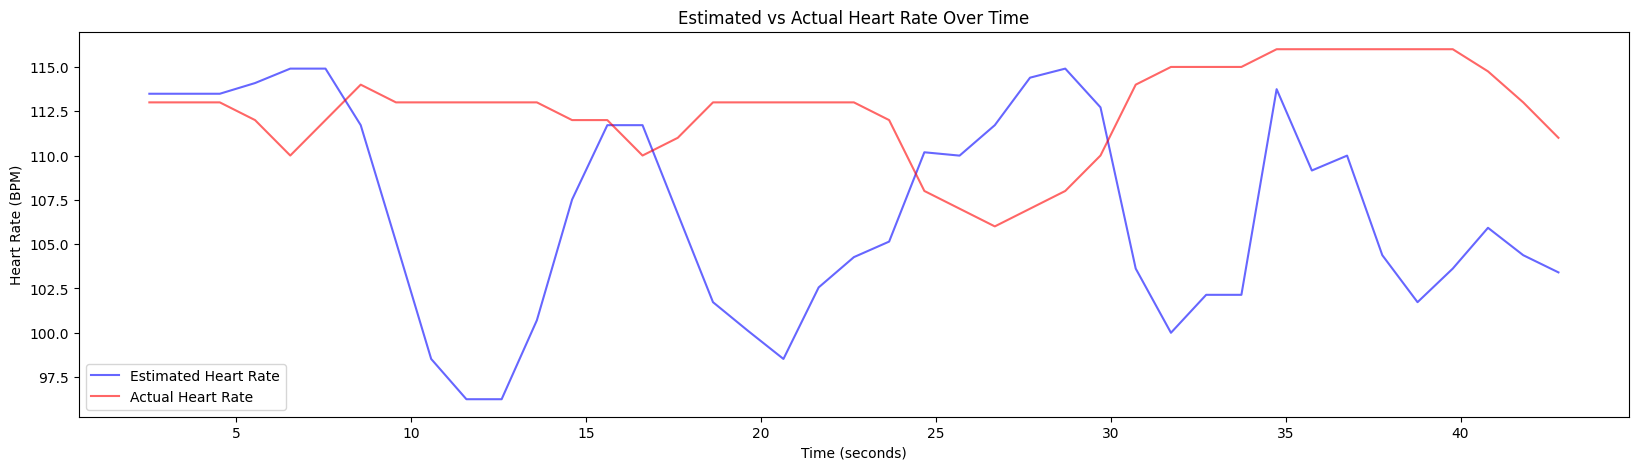

Average Estimated Heart Rate: 106.85
Average Actual Heart Rate: 112.53
MAE: 7.68
RMSE: 9.13
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject40.npz...


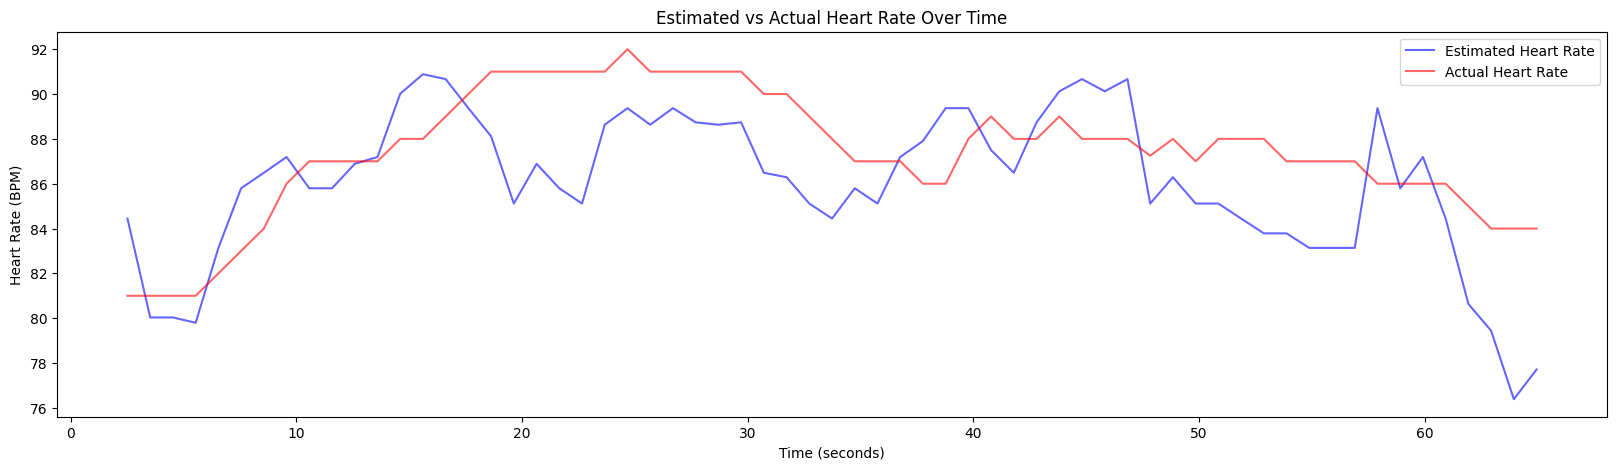

Average Estimated Heart Rate: 86.06
Average Actual Heart Rate: 87.40
MAE: 2.56
RMSE: 3.00
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject41.npz...


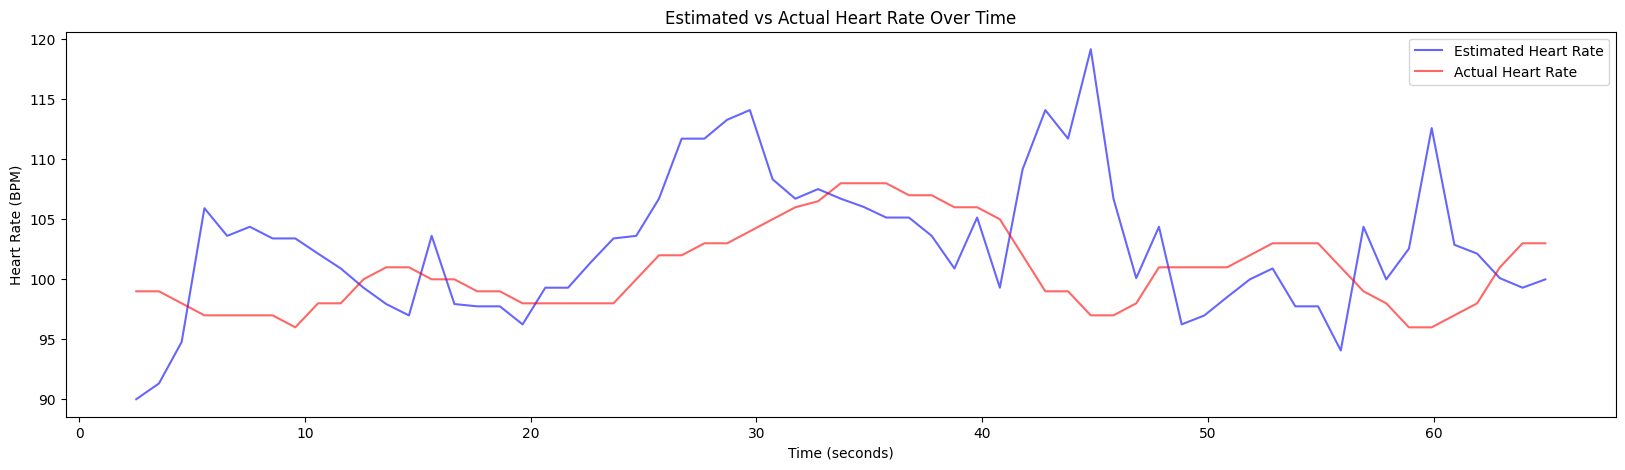

Average Estimated Heart Rate: 102.83
Average Actual Heart Rate: 100.82
MAE: 5.10
RMSE: 6.52
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject42.npz...


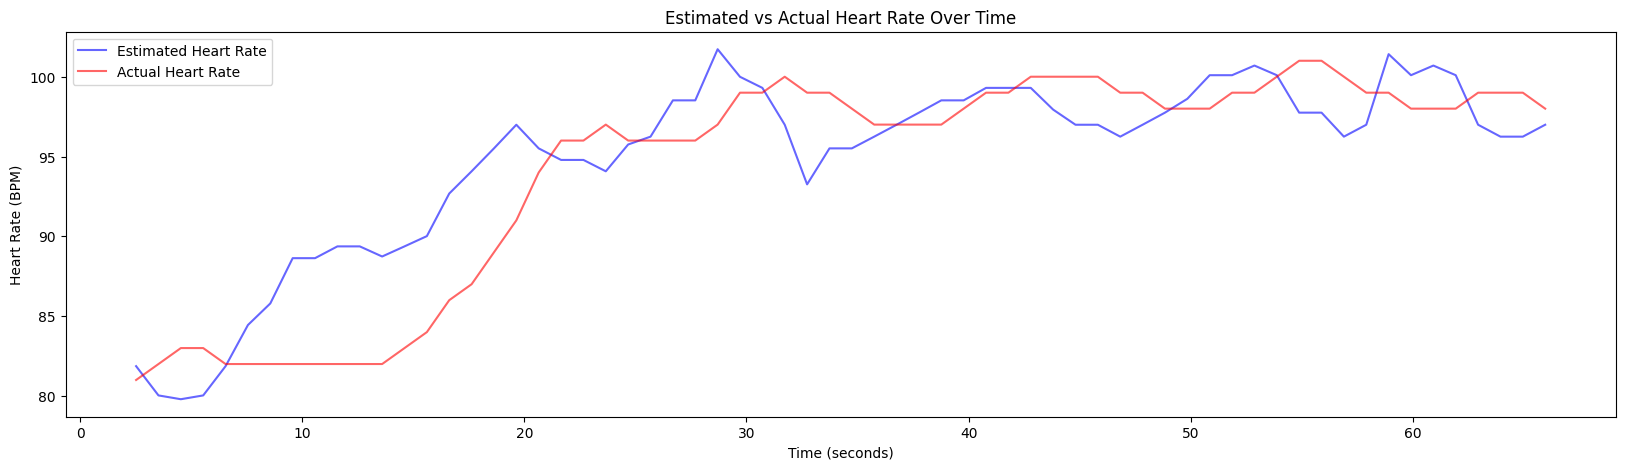

Average Estimated Heart Rate: 94.90
Average Actual Heart Rate: 94.16
MAE: 2.74
RMSE: 3.48
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject43.npz...


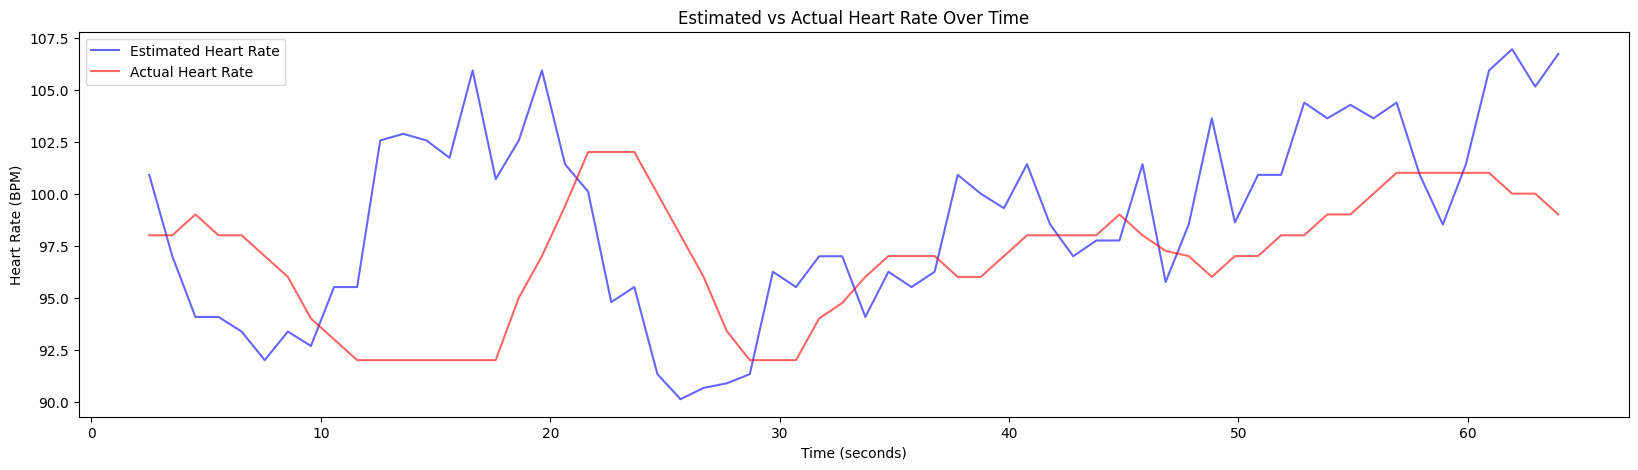

Average Estimated Heart Rate: 98.80
Average Actual Heart Rate: 96.96
MAE: 4.27
RMSE: 5.28
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject44.npz...


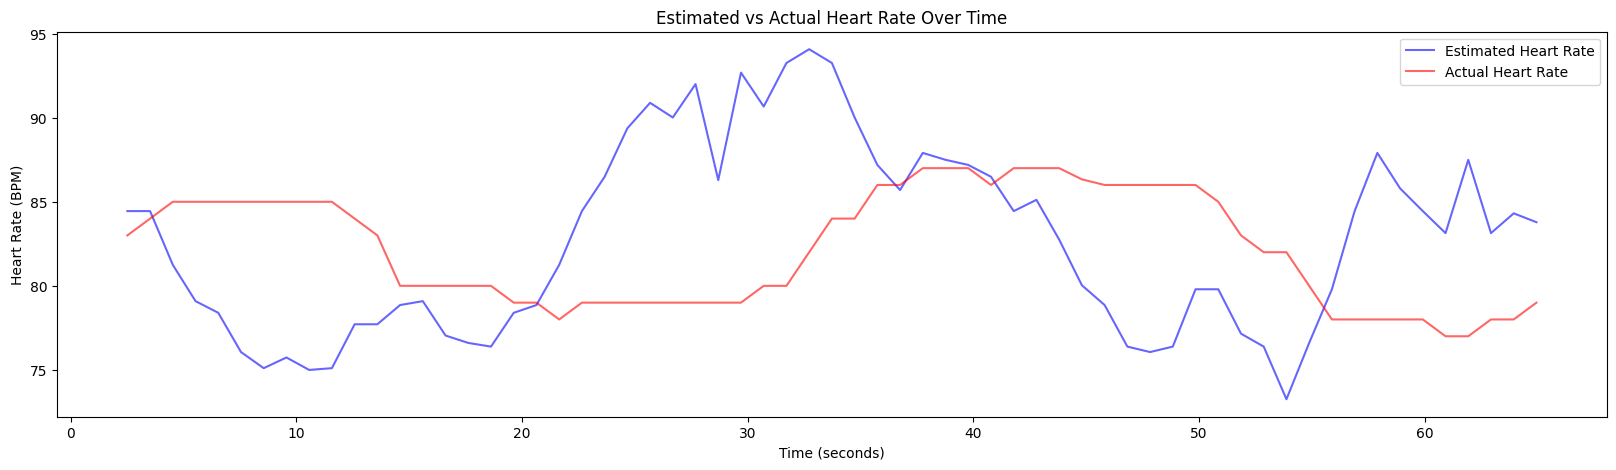

Average Estimated Heart Rate: 82.69
Average Actual Heart Rate: 82.21
MAE: 6.04
RMSE: 7.13
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject45.npz...


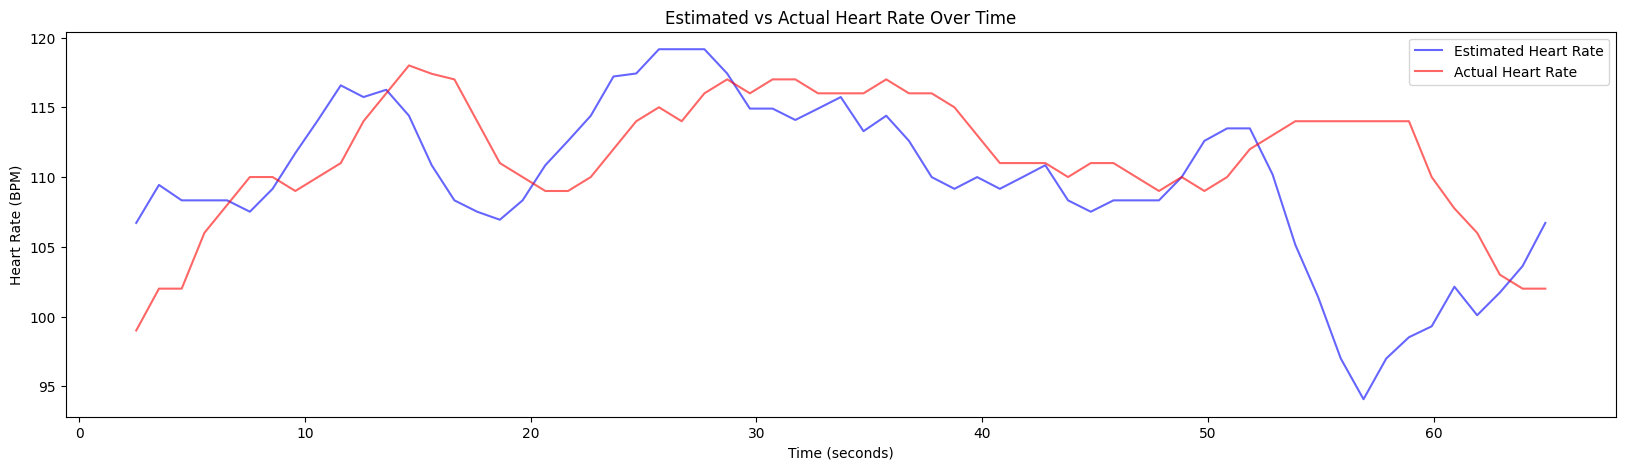

Average Estimated Heart Rate: 109.80
Average Actual Heart Rate: 111.56
MAE: 4.45
RMSE: 6.16
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject46.npz...


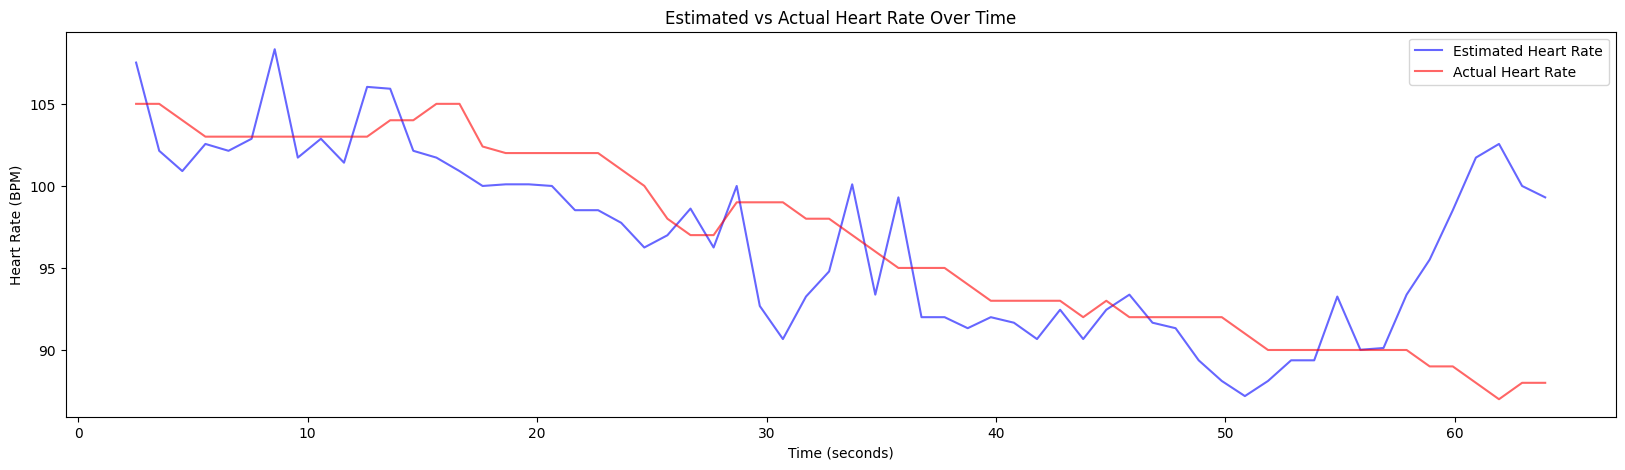

Average Estimated Heart Rate: 96.68
Average Actual Heart Rate: 96.67
MAE: 3.20
RMSE: 4.55
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject47.npz...


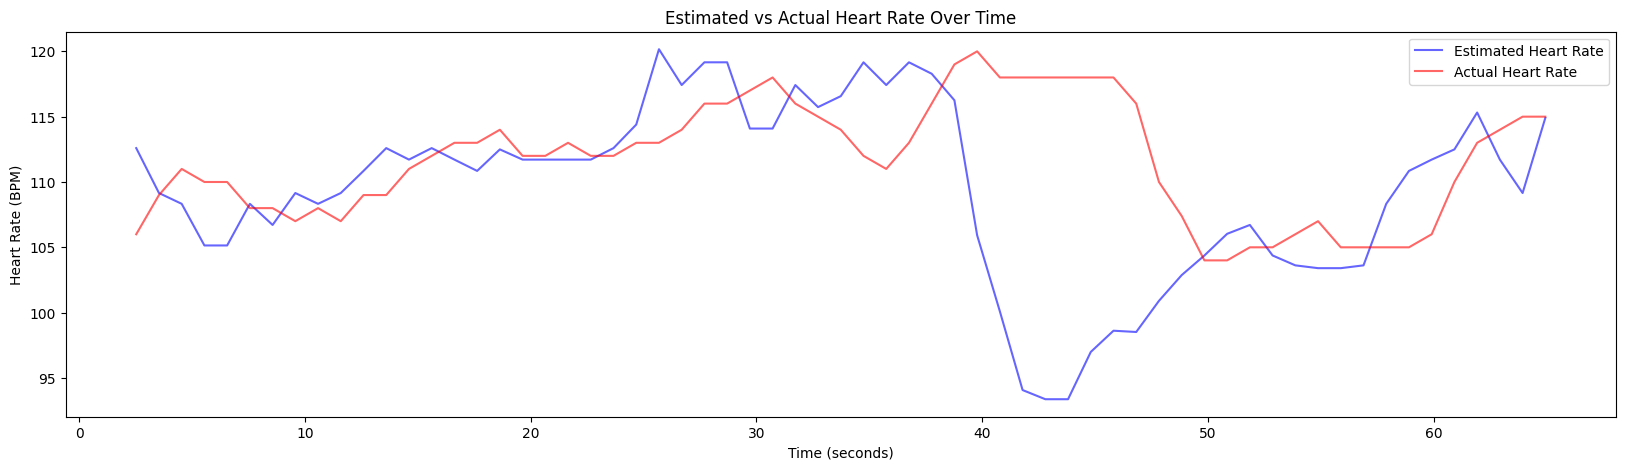

Average Estimated Heart Rate: 109.48
Average Actual Heart Rate: 111.66
MAE: 4.96
RMSE: 8.06
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject48.npz...


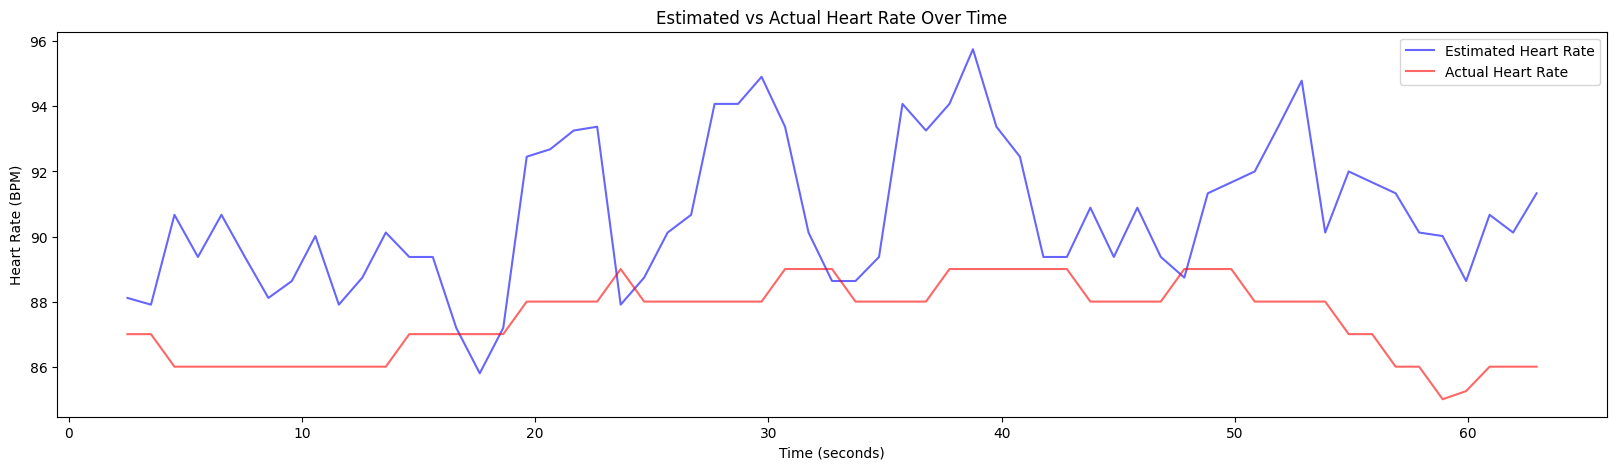

Average Estimated Heart Rate: 90.67
Average Actual Heart Rate: 87.48
MAE: 3.29
RMSE: 3.81
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject49.npz...


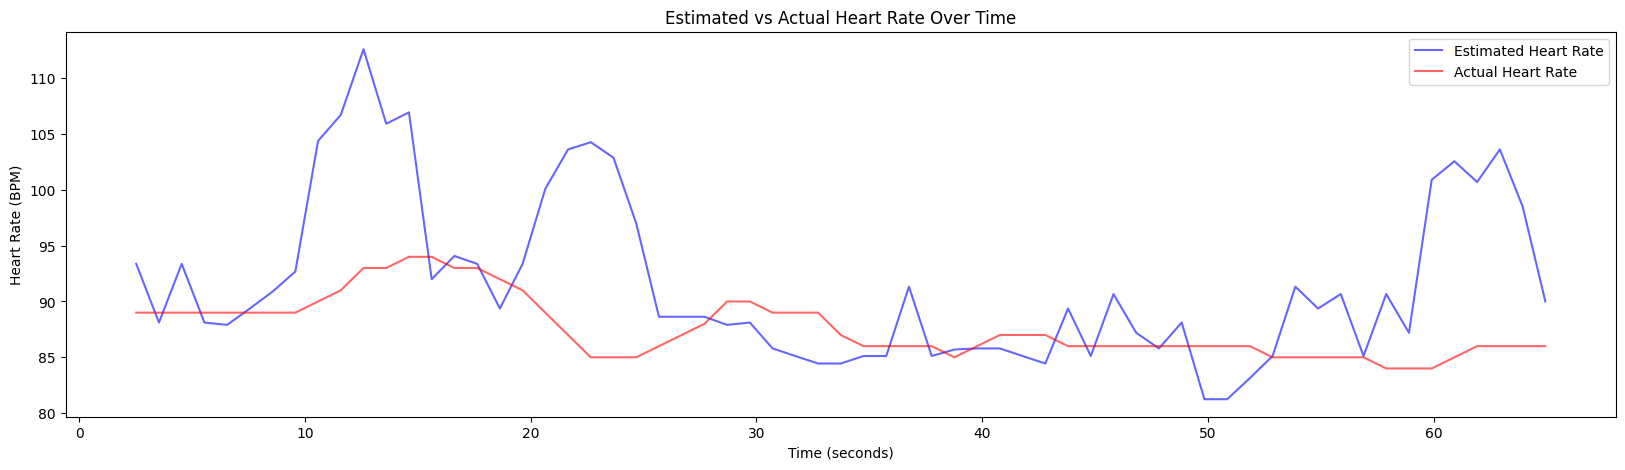

Average Estimated Heart Rate: 91.64
Average Actual Heart Rate: 87.59
MAE: 5.56
RMSE: 8.09
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject5.npz...


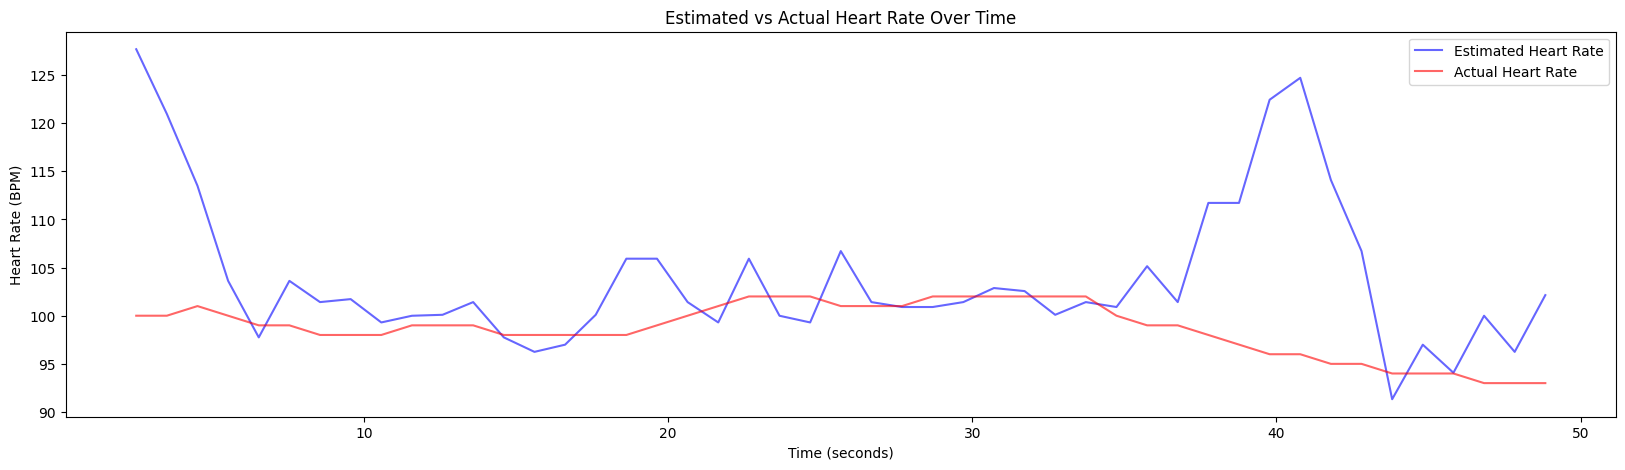

Average Estimated Heart Rate: 103.78
Average Actual Heart Rate: 98.66
MAE: 5.87
RMSE: 9.51
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject8.npz...


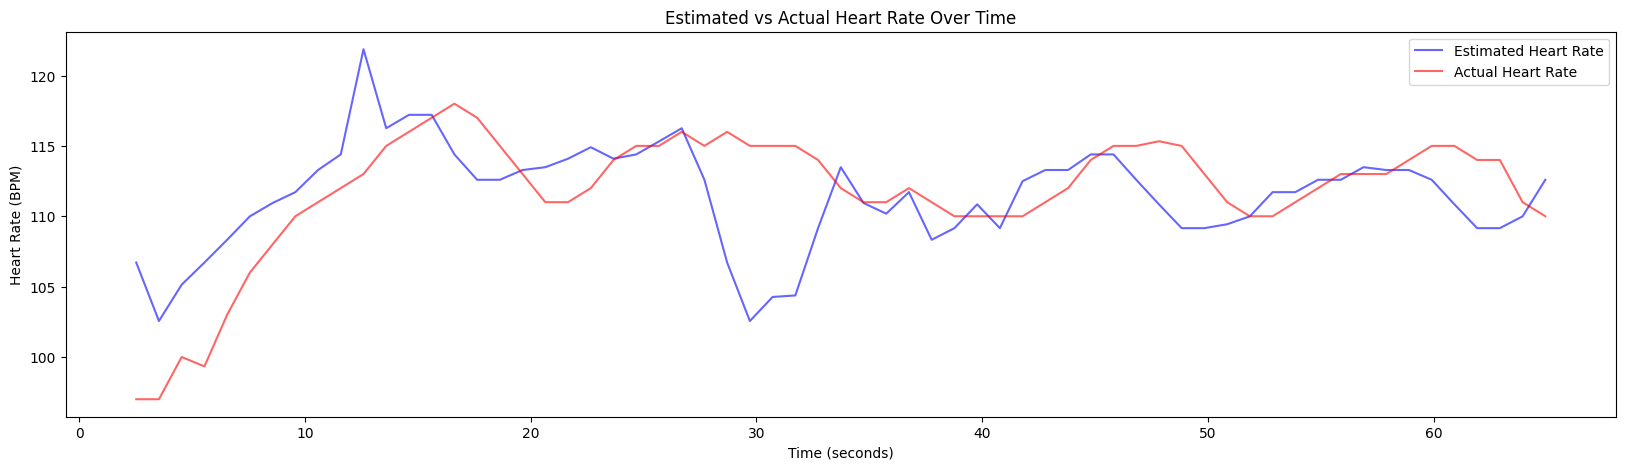

Average Estimated Heart Rate: 111.48
Average Actual Heart Rate: 111.82
MAE: 2.96
RMSE: 4.18
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject9.npz...


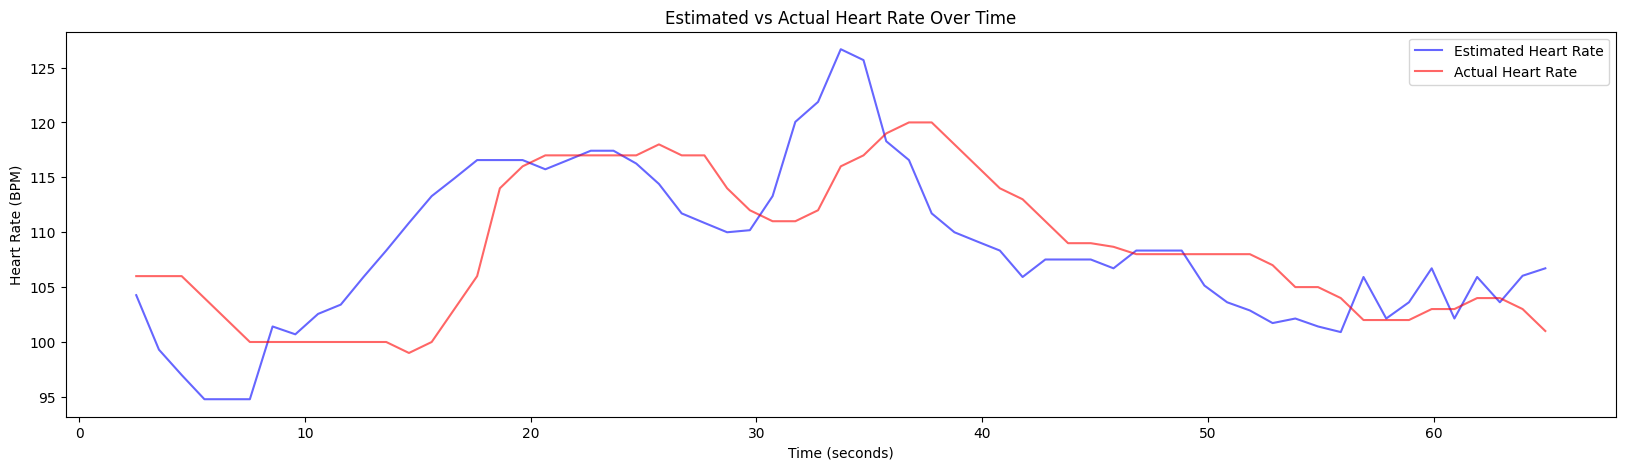

Average Estimated Heart Rate: 108.55
Average Actual Heart Rate: 108.61
MAE: 4.36
RMSE: 5.57
---------------------------------------------------------------------------


In [33]:
directory = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/'

rmse_list, mae_list, subject_list = process_npz_files(directory)

In [34]:
# 모든 파일의 MAE 출력
print("MAE List:", mae_list)
print("Average MAE across all files:", np.mean(mae_list))
print("---------------------------------------------------------------------------")

MAE List: [3.2462010839681787, 2.57502495546585, 3.335774451391518, 3.349889836223513, 3.6517048466876916, 9.209187255934163, 1.8572193339211902, 2.871932061748531, 2.828255385579837, 2.915169022802879, 4.237078971160741, 3.006542938994081, 4.475704846064459, 6.934117597536398, 23.87912802979404, 24.603542418830568, 21.05570523643353, 9.109181213460229, 5.841227889181589, 3.1743949551833146, 4.25484261427391, 3.570768491195952, 2.573578440306342, 2.9088930901090233, 3.1334617613159987, 13.496921901729799, 1.6415490592171729, 11.284481056204665, 7.676313057725134, 2.5589962283621466, 5.097836139748982, 2.74282890629451, 4.271583407148067, 6.036919819657055, 4.452925751864083, 3.203314092051205, 4.963948032181854, 3.289278768457689, 5.5643914875913065, 5.872182154879137, 2.962295298891172, 4.361575283103689]
Average MAE across all files: 5.90656826601598
---------------------------------------------------------------------------


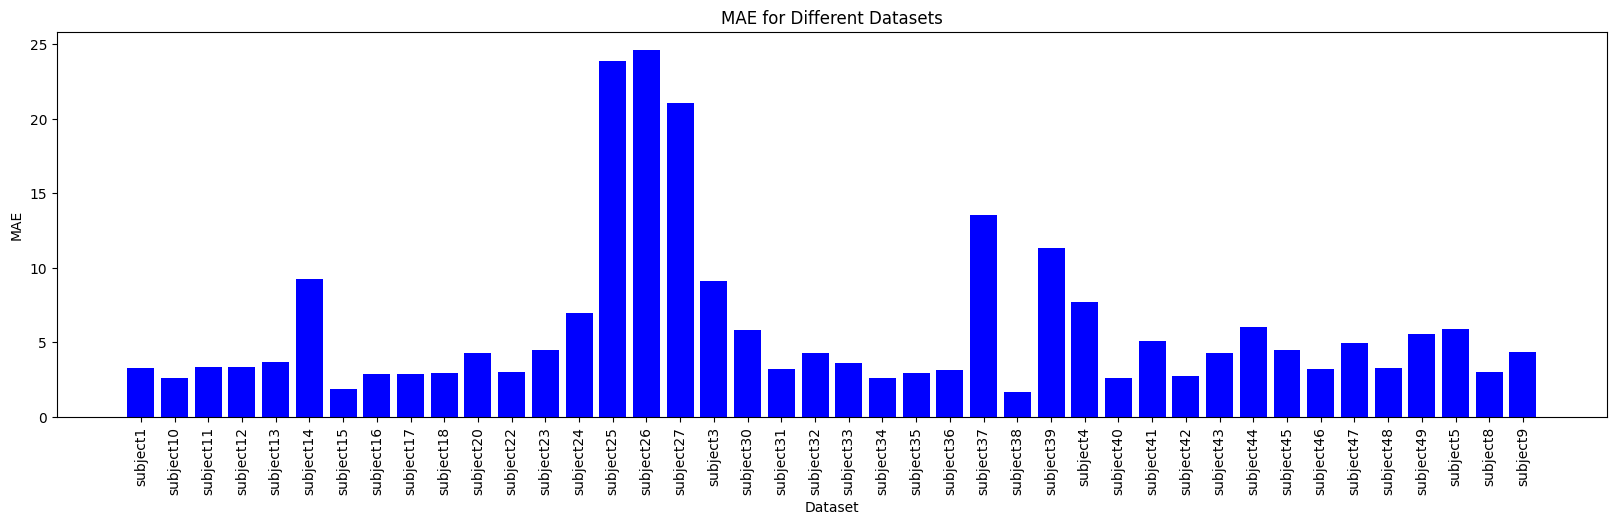

In [27]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, mae_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('MAE')
plt.title('MAE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()

In [28]:
# 모든 파일의 RMSE 출력
print("RMSE List:", rmse_list)
print("Average RMSE across all files:", np.mean(rmse_list))
print("---------------------------------------------------------------------------")

RMSE List: [4.3725506010106505, 3.20067667115702, 4.157578834814566, 5.373742004615766, 4.472708027381371, 11.430412153801015, 2.216593488116308, 4.0673520551585725, 3.845299086588865, 4.573314827467044, 5.089721027826796, 3.87211853972051, 5.630398120148656, 9.52293611955167, 24.189611958965095, 24.905831986672126, 22.388892268701373, 11.09841822015165, 8.763722738411923, 3.959375623093034, 5.855369738497496, 4.744642635020066, 3.0451345297446064, 3.7441601095089903, 4.108331653453547, 16.184706914538836, 2.268864057792907, 15.505665590830093, 9.12583019487151, 2.9997599176580483, 6.523290517906812, 3.4795953065868783, 5.281563533444852, 7.1265175081146905, 6.1607612967687135, 4.554089736563683, 8.05516184038324, 3.806982796476391, 8.094032900380185, 9.51361597659443, 4.182147687382835, 5.570834175149371]
Average RMSE across all files: 7.311007451691005
---------------------------------------------------------------------------


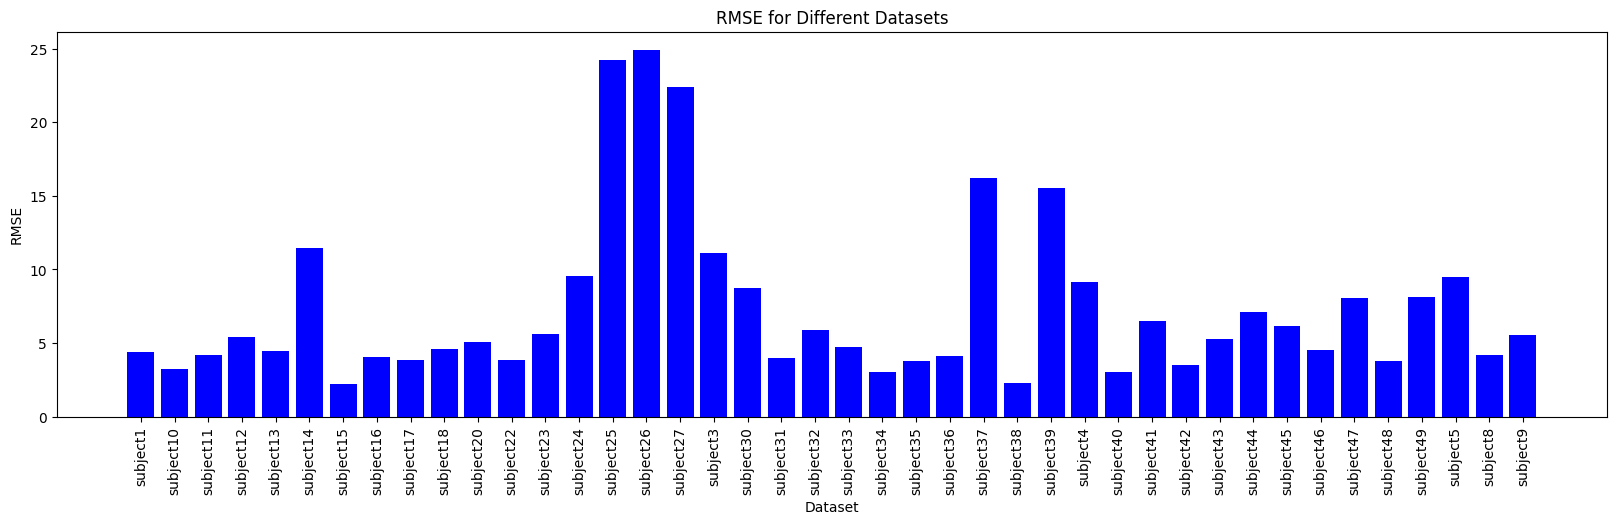

In [29]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, rmse_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()